#ARIMA모델로 주식을 분석해보자!



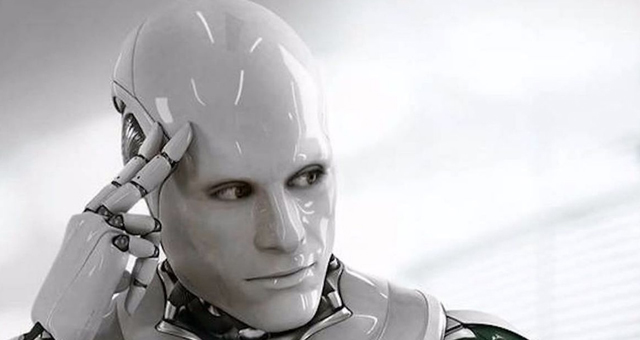

####그전에 **ARIMA** 모델이란?

####ARIMA를 알기전에 먼저 **ARMA를 짚어볼 필요**가 있습니다.

####ARMA모델은 **AR(자기회귀)과 MA(이동평균)를 섞은 모델**로 연구기관에서 사용합니다.

####즉, AR, MA 두 가지 관점에서 **과거의 데이터를 사용**하는 것이 ARMA입니다.

####그럼 ARIMA는 뭘까요?

####**자동 회귀 누적 이동 평균**이라고 한다고 하네요

####ARMA와는 다르게 **과거 데이터의 선형 관계뿐만이 아니라 추세까지 고려한 모델**이라고 합니다.

####이번 프로젝트에서는 ARIMA로 모델 선언, 학습과 어떻게 하면 성능이 우수할 수 있을지 보겠습니다.

#사전 준비

In [4]:
!pip install statsmodels

In [1]:
#나중에 구글드라이브에 저장된 csv파일을 가지고 올것이므로
#구글 드라이브를 임포트 시킵니다.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**구글 드라이브에 올려놓은 3개의 주식 데이터를 가지고 올것**이기 때문에 구글 드라이브를 임포트 시켜줍니다.

#라이브러리 임포트

In [2]:
#필요한 라이브러리 미리 지정
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


미리 필요한 라이브러리 들을 임포트 시킵니다.


```
rcParams['figure.figsize'] = 15, 6
```
라는 코드는 차트의 **기본 크기를 15*6으로 지정**해줘 라는 뜻입니다.

그렇게하면 코드가 실행될때마다 저 사이즈로 실행되니 따로 사이즈를 

지정해주는 **불편함을 해소**할수 있겠네요


#주식 데이터 불러오기

저는

1.HMM

2.KCTC

3.기아

3가지 주식을 한꺼번에 예측해보겠습니다.

In [3]:
HMM = pd.read_csv('/content/drive/MyDrive/pic/HMM.csv')
print(HMM.tail())
print()

KCTC = pd.read_csv('/content/drive/MyDrive/pic/KCTC.csv')
print(KCTC.tail())
print()

KIA = pd.read_csv('/content/drive/MyDrive/pic/기아.csv')
print(KIA.tail())

           Date     Open     High      Low    Close  Adj Close   Volume
241  2022-04-28  27100.0  28500.0  26950.0  28500.0    28500.0  5584595
242  2022-04-29  28700.0  28750.0  27900.0  28400.0    28400.0  3595636
243  2022-05-02  27750.0  29000.0  27700.0  28950.0    28950.0  3406043
244  2022-05-03  29250.0  29450.0  28850.0  28900.0    28900.0  2519124
245  2022-05-04  29350.0  29400.0  28300.0  29200.0    29200.0  2661654

           Date    Open    High     Low   Close  Adj Close  Volume
241  2022-04-28  6600.0  6620.0  6380.0  6380.0     6380.0  479897
242  2022-04-29  6480.0  6490.0  6290.0  6310.0     6310.0  252470
243  2022-05-02  6220.0  6320.0  6170.0  6270.0     6270.0  188455
244  2022-05-03  6290.0  6380.0  6230.0  6250.0     6250.0  134765
245  2022-05-04  6260.0  6290.0  6040.0  6080.0     6080.0  288682

           Date     Open     High      Low    Close  Adj Close   Volume
241  2022-04-28  84200.0  84300.0  83100.0  83700.0    83700.0  1382712
242  2022-04-29  835

데이터가 순서대로 쌓여서 뒷부분이 최신 데이터이므로 **tail 메소드를 사용하여 출력**해보았습니다.

**tail메소드는 맨 뒤에 5개를 출력**해줍니다.

컬럼은 **날짜, 시작가, 최고기, 최저가, 종료가, 거래량**을 나타내는거 같습니다.

In [4]:
print(HMM.info())
print()

print(KCTC.info())
print()

print(KIA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       246 non-null    object 
 1   Open       246 non-null    float64
 2   High       246 non-null    float64
 3   Low        246 non-null    float64
 4   Close      246 non-null    float64
 5   Adj Close  246 non-null    float64
 6   Volume     246 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       246 non-null    object 
 1   Open       246 non-null    float64
 2   High       246 non-null    float64
 3   Low        246 non-null    float64
 4   Close      246 non-null    float64
 5   Adj Close  246 non-null    float64
 6   Volume     246 non-null    int64  
dty

정보도 한번 출력해봤습니다.

**데이터는 알맞게 잘 들어있는거** 같습니다.

In [5]:
HMM.describe()

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.00000,246.000000,2.460000e+02
mean,33739.024390,34482.723577,33013.617886,33664.02439,33094.933078,5.765065e+06
std,7825.934218,8042.060117,7582.964764,7813.02918,7475.077228,5.234755e+06
min,21950.000000,22150.000000,21100.000000,21900.00000,21900.000000,0.000000e+00
25%,27012.500000,27650.000000,26562.500000,26925.00000,26701.617676,2.740881e+06
50%,30375.000000,31075.000000,29550.000000,29950.00000,29625.000000,4.103370e+06
75%,40950.000000,41950.000000,40200.000000,40837.50000,39876.618164,7.172963e+06
max,50100.000000,51100.000000,49100.000000,50600.00000,49409.410156,3.350936e+07


In [6]:
KCTC.describe()

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,6722.032520,6906.869919,6599.735772,6705.325203,6660.367144,1.279154e+06
std,978.207823,1035.025564,935.438362,949.349345,925.370443,3.697686e+06
min,4850.000000,5040.000000,4735.000000,4850.000000,4850.000000,0.000000e+00
25%,5960.000000,6125.000000,5930.000000,5972.500000,5944.230713,1.479310e+05
50%,6505.000000,6655.000000,6375.000000,6480.000000,6442.451904,2.830585e+05
75%,7597.500000,7717.500000,7337.500000,7530.000000,7457.596191,6.696062e+05
max,9560.000000,10050.000000,8820.000000,9150.000000,9062.019531,3.738858e+07


In [7]:
KIA.describe()

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,82391.056911,83302.845528,81561.788618,82342.276423,80360.821107,1.636972e+06
std,5099.635971,5160.291088,4958.283448,5010.373046,4142.455868,9.357613e+05
min,68800.000000,68800.000000,68300.000000,68800.000000,68800.000000,0.000000e+00
25%,79875.000000,80925.000000,78625.000000,79800.000000,78341.269531,1.106460e+06
50%,83500.000000,84300.000000,82700.000000,83400.000000,80921.304688,1.456090e+06
75%,85875.000000,86600.000000,84775.000000,85800.000000,83284.023438,2.021144e+06
max,91300.000000,93700.000000,90300.000000,91500.000000,88251.476563,6.187345e+06


한번 describe도 확인해봅시다.

보시면 **행은 똑같이 246으로 맞춰져있는걸 확인**하실수있습니다.

**거래량?도 0으로 맞춰져있네요**

---

#Date를 인덱스로 종료가 출력

In [8]:
HMM['Date'] = pd.to_datetime(HMM['Date'])
HMM.set_index("Date", inplace=True)
HMT = HMM['Close']
HMT.tail()

Date
2022-04-28    28500.0
2022-04-29    28400.0
2022-05-02    28950.0
2022-05-03    28900.0
2022-05-04    29200.0
Name: Close, dtype: float64

In [9]:
KCTC['Date'] = pd.to_datetime(KCTC['Date'])
KCTC.set_index("Date", inplace=True)
KCT = KCTC['Close']
KCT.tail()

Date
2022-04-28    6380.0
2022-04-29    6310.0
2022-05-02    6270.0
2022-05-03    6250.0
2022-05-04    6080.0
Name: Close, dtype: float64

In [10]:
KIA['Date'] = pd.to_datetime(KIA['Date'])
KIA.set_index("Date", inplace=True)
KIT = KIA['Close']
KIT.tail()

Date
2022-04-28    83700.0
2022-04-29    83800.0
2022-05-02    84400.0
2022-05-03    83500.0
2022-05-04    83500.0
Name: Close, dtype: float64

코드를 보게되면 **Date 자료형을 datetime으로 지정**하였습니다.

나중에 필요한 경우가 생길까봐 Date 자료형을 변환 시켰습니다.

그리고 주식 데이터를 작업할때는 저런 방식이 좋다고도 들었습니다.

그 다음 **set_index를 사용하여 Date를 index로 사용하므로써 출력하여 저렇게 보여**집니다.

즉, 이번 프로젝트에서는 **종료가를 가지고 주식 가격을 예측한다는 의미** 입니다.

가장 최신 날짜까지 업데이트가 아주 잘 되어있네요

기대가 됩니다.

---

#결측값 및 시각화하기

Series([], Name: Close, dtype: float64)


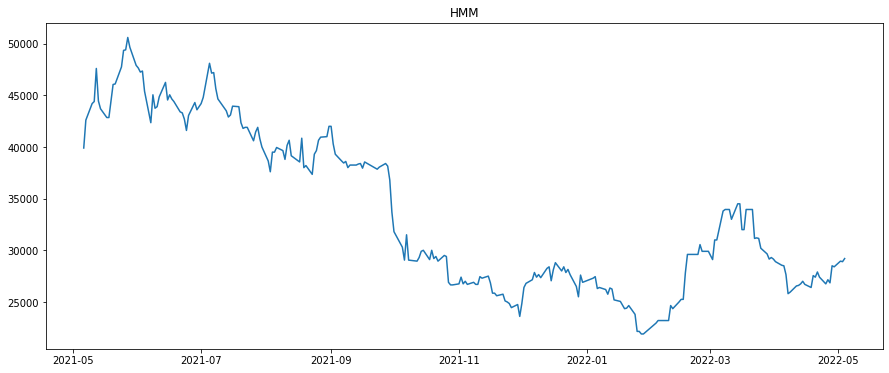

Series([], Name: Close, dtype: float64)


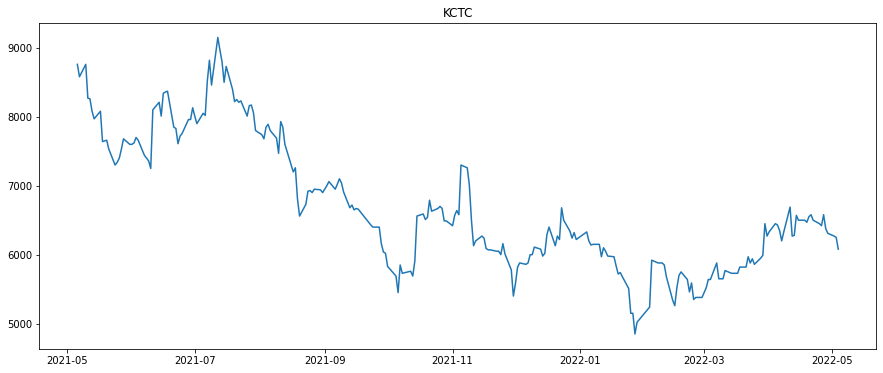

Series([], Name: Close, dtype: float64)


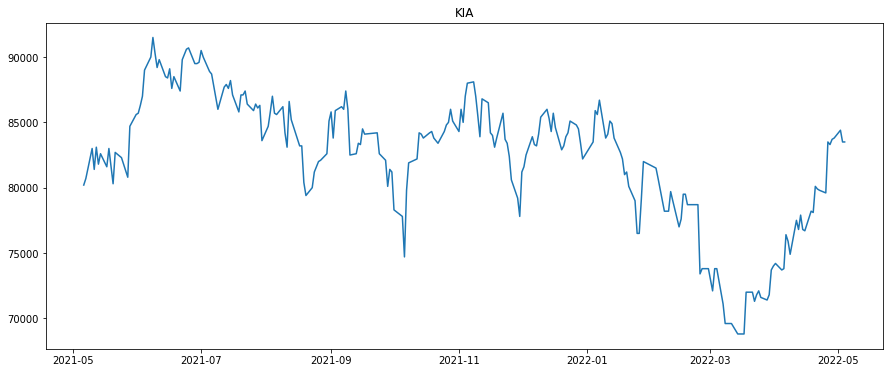

In [11]:
LI = {'HMM' : HMT, 'KCTC' : KCT, 'KIA' : KIT}

for i,j in LI.items():
  j = j.interpolate(method='time')
  print(j[j.isna()])
  plt.plot(j)
  plt.title(i)
  plt.show()

결측치가 있는지 확인해보고 차트로 표현을 해보겠습니다.

3가지 다 차트가 아주 화려합니다.

맨 위에서 부터 **HMM, KCTC, KIA** 순입니다.

대부분 주식이 **크게 몇번 꼴아박은걸 볼 수 있습니다**.

**일정한 규칙이라고는 찾아볼수없습니다**.

차트를 보니 과연 잘 예측을 할 수 있을지 궁금하긴 하네요

---

#데이터를 Stationary하게 만들어보자

In [12]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Result of Dickey-Fuller Test:')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Ciritical value (%s)' % key] = value
    print(dfoutput)

이제 위에서 다운받은 통계패키지인 **statsmodels 패키지에서 제공하는 adfuller 메소드를 이용**하겠습니다.

위 함수는 **p-value를 보여줍니다**. 

그것을 토대로 **귀무가설(p-value = 1)을 기각하여 안정적인 시계열 데이터라는 것을 입증시킬겁니다**.

만약 귀무가설을 기각시키지 못해도 걱정하지마십쇼, 그럴 경우를 위해서 지금 **데이터를 Stationary하게 만드는 작업을 할겁니다**.

귀무가설은 **통계학에서 처음부터 버릴 것을 예상**하는 가설입니다.

즉, 차이가 없거나 의미있는 차이가 없는 경우의 가설입니다.

귀무가설과 같이 쓰는 가설로 **대립가설**이 존재합니다.

대립가설이란

**귀무가설이 거짓이라면 대안적으로 참이 되는 가설**입니다.

최종적으로 시계열에서는 **귀무가설 p-value가 1**이

기각 되면서 **대립가설 p-value가 1이 확실하게 아닌값**이 채택되면 그 데이터는 **정상성이 있다**고 합니다.

####도데체 왜 이따구로 만들었는지는 모르겠지만 일단 계속 진행해보겠습니다.

In [13]:
def plot_rolling_statistics(timeseiries, window=12) :
    
    rolmean = timeseiries.rolling(window=window).mean() 
    rolstd = timeseiries.rolling(window=window).std() 
    
    orig = plt.plot(timeseiries, color="blue", label="Original")
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

위의 함수는 **원본시계열, 이동평균, 이동표준편차**를 시각화하여 보여줍니다.

In [14]:
for i, j in LI.items():
  print(i)
  augmented_dickey_fuller_test(j)
  print()

HMM
Result of Dickey-Fuller Test:
Test Statistic                  -1.145455
p-value                          0.696609
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64

KCTC
Result of Dickey-Fuller Test:
Test Statistic                  -2.311337
p-value                          0.168338
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64

KIA
Result of Dickey-Fuller Test:
Test Statistic                  -2.199151
p-value                          0.206554
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)    



```
augmented_dickey_fuller_test
```
라는 함수를 사용하여 3가지 주식데이터를 출력해봤습니다.

아닌것도 존재하지만 비교적 p-value가 **1에 가깝게 나온것을 확인**하실수가 있습니다.

이러면 **귀무가설을 기각할 수 없으므로 안정적인 시계열이 아니게 됩니다**.

그럼 어떤식으로 데이터를 가공하여 귀무가설을 기각할수 있게 만들어야 할까요?

지금부터 해봅시다.

---

#Stationary하게 만들기

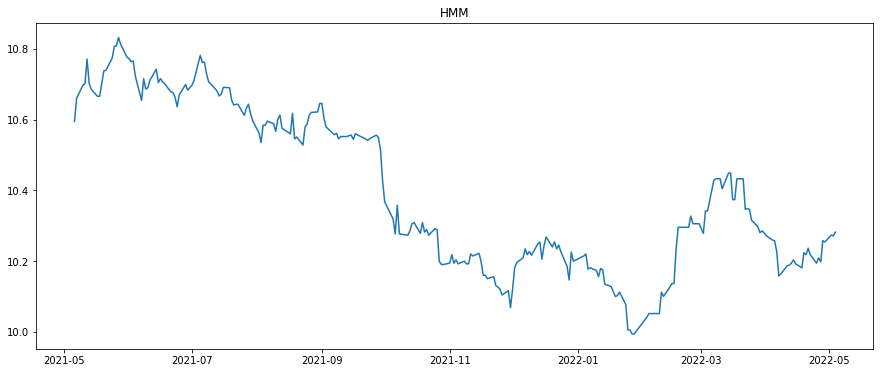

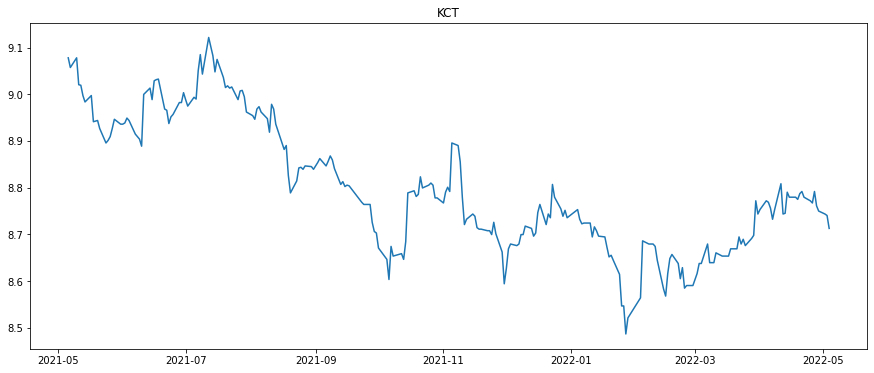

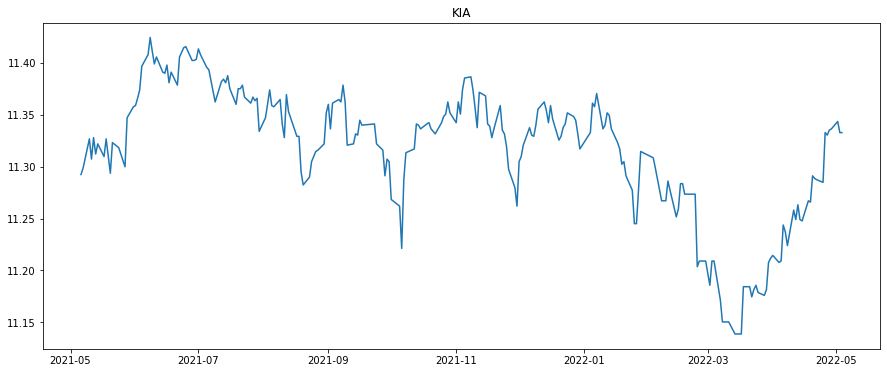

In [15]:
HMT_log = np.log(HMT)
plt.plot(HMT_log)
plt.title('HMM')
plt.show()

KCT_log = np.log(KCT)
plt.plot(KCT_log)
plt.title('KCT')
plt.show()

KIT_log = np.log(KIT)
plt.plot(KIT_log)
plt.title('KIA')
plt.show()

보통 **분산이 점점 커지고 있는 추세를 보일때 로그함수를 사용하는것이 적절**합니다.

**다른 데이터면 몰라도 지금 이 데이터에서는 좋은 방법이 아닙니다**.

한번 실행시켜 보겠습니다.

In [16]:
LI1 = {'HMM' : HMT_log, 'KCTC' : KCT_log, 'KIA' : KIT_log}

for i,j in LI1.items():
  print(i)
  augmented_dickey_fuller_test(j)
  print()

HMM
Result of Dickey-Fuller Test:
Test Statistic                  -1.176053
p-value                          0.683811
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64

KCTC
Result of Dickey-Fuller Test:
Test Statistic                  -2.228901
p-value                          0.195924
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64

KIA
Result of Dickey-Fuller Test:
Test Statistic                  -2.166732
p-value                          0.218541
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)    

별 차이가 없습니다.

왜 그럴까요?

위에서 말씀드린데로 **시계열에서 분산이 점점 커지고 있는 추세를 보일때 로그함수를 사용하는것이 적절**합니다.

하지만 차트를 확인해보면 **점점 커지고 있는 추세는 나타나지 않습니다**.

오히려 뒤죽박죽 입니다.

그럼 이대로 끝인가요?

아닙니다 **다른 방법도 존재**합니다.

---

#추세 상쇄하기

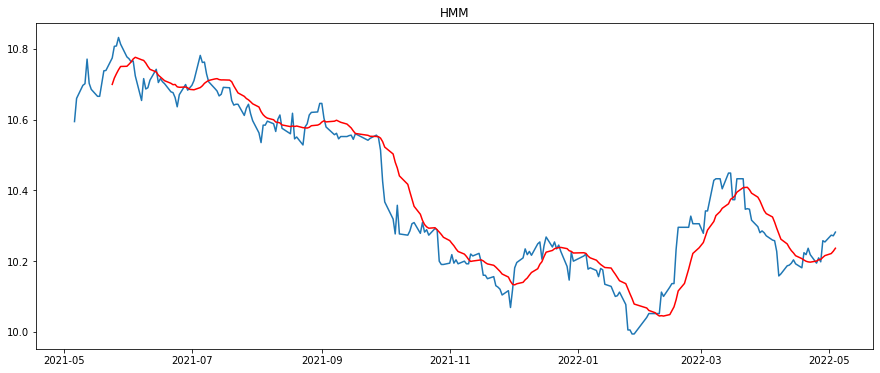

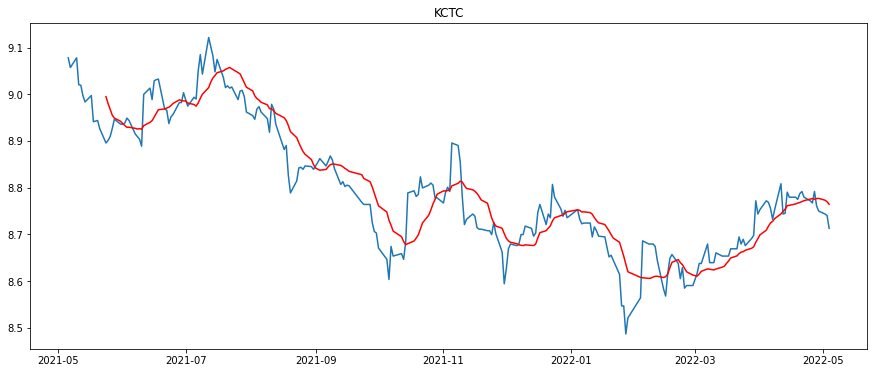

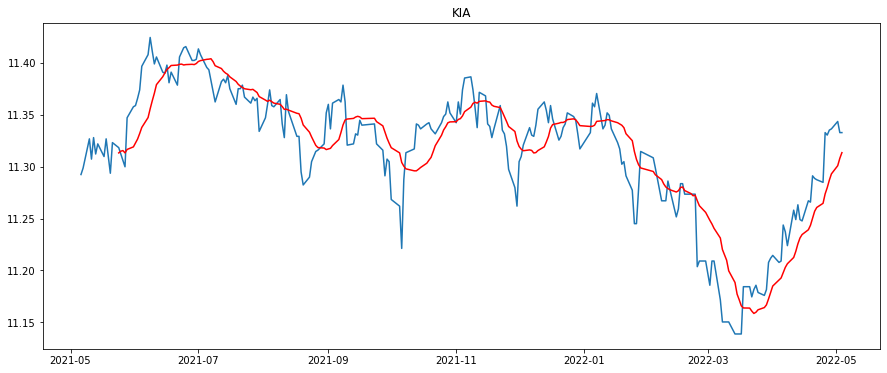

In [17]:
HMT_moving_avg = HMT_log.rolling(window=12).mean()
plt.title("HMM")
plt.plot(HMT_log)
plt.plot(HMT_moving_avg, color='red')
plt.show()

KCT_moving_avg = KCT_log.rolling(window=12).mean()
plt.title("KCTC")
plt.plot(KCT_log)
plt.plot(KCT_moving_avg, color='red')
plt.show()

KIT_moving_avg = KIT_log.rolling(window=12).mean()
plt.title("KIA")
plt.plot(KIT_log)
plt.plot(KIT_moving_avg, color='red')
plt.show()

시계열 분석에서 위와 같이 **시간 추이에 따라 나타나는 평균값 변화를 추세**라고 합니다.

이것을 **상쇄시키기 위해 Moving에서 rolling mean를 구한다음 - (주식이름)_log 해줍니다**.

In [18]:
HMT_log_moving_avg = HMT_log - HMT_moving_avg
HMT_log_moving_avg.head(15)

Date
2021-05-06         NaN
2021-05-07         NaN
2021-05-10         NaN
2021-05-11         NaN
2021-05-12         NaN
2021-05-13         NaN
2021-05-14         NaN
2021-05-17         NaN
2021-05-18         NaN
2021-05-20         NaN
2021-05-21         NaN
2021-05-24    0.074590
2021-05-25    0.089835
2021-05-26    0.078506
2021-05-27    0.091239
Name: Close, dtype: float64

In [19]:
KCT_log_moving_avg = KCT_log - KCT_moving_avg
KCT_log_moving_avg.head(15)

Date
2021-05-06         NaN
2021-05-07         NaN
2021-05-10         NaN
2021-05-11         NaN
2021-05-12         NaN
2021-05-13         NaN
2021-05-14         NaN
2021-05-17         NaN
2021-05-18         NaN
2021-05-20         NaN
2021-05-21         NaN
2021-05-24   -0.099170
2021-05-25   -0.078967
2021-05-26   -0.058497
2021-05-27   -0.028473
Name: Close, dtype: float64

In [20]:
KIT_log_moving_avg = KIT_log - KIT_moving_avg
KIT_log_moving_avg.head(15)

Date
2021-05-06         NaN
2021-05-07         NaN
2021-05-10         NaN
2021-05-11         NaN
2021-05-12         NaN
2021-05-13         NaN
2021-05-14         NaN
2021-05-17         NaN
2021-05-18         NaN
2021-05-20         NaN
2021-05-21         NaN
2021-05-24    0.005051
2021-05-25   -0.002689
2021-05-26   -0.009437
2021-05-27   -0.013368
Name: Close, dtype: float64

추세를 빼주니 앞부분에서 몇개를 **계산이 이뤄지지 않아 결측치가 발생**하였습니다.

왜 그럴까요?

답은 **window size를 12까지 설정**해서 입니다.

그래서 **앞부분인 11개의 데이터는 계산에 포함이 되지 않습니다**.

마음이 아프지만 제거해주겠습니다.

In [21]:
LI2 = {'HMM' : HMT_log_moving_avg, 'KCTC' : KCT_log_moving_avg, 'KIA' : KIT_log_moving_avg}

for i, j in LI2.items():
  print(i)
  j.dropna(inplace=True)
  print(j.head(15))
  print()

HMM
Date
2021-05-24    0.074590
2021-05-25    0.089835
2021-05-26    0.078506
2021-05-27    0.091239
2021-05-28    0.062972
2021-05-31    0.026566
2021-06-01    0.015540
2021-06-02    0.000601
2021-06-03   -0.005607
2021-06-04   -0.052479
2021-06-07   -0.115042
2021-06-08   -0.051318
2021-06-09   -0.073308
2021-06-10   -0.060134
2021-06-11   -0.030672
Name: Close, dtype: float64

KCTC
Date
2021-05-24   -0.099170
2021-05-25   -0.078967
2021-05-26   -0.058497
2021-05-27   -0.028473
2021-05-28   -0.002581
2021-05-31   -0.006112
2021-06-01   -0.001009
2021-06-02    0.005362
2021-06-03    0.019820
2021-06-04    0.014394
2021-06-07   -0.012319
2021-06-08   -0.016259
2021-06-09   -0.022361
2021-06-10   -0.036391
2021-06-11    0.066939
Name: Close, dtype: float64

KIA
Date
2021-05-24    0.005051
2021-05-25   -0.002689
2021-05-26   -0.009437
2021-05-27   -0.013368
2021-05-28    0.030459
2021-05-31    0.038559
2021-06-01    0.035845
2021-06-02    0.039170
2021-06-03    0.041909
2021-06-04    0.0

데이터를 봐도 숫자가 되게 정신이 없게 생겼습니다.

시각화를 해보져

HMM


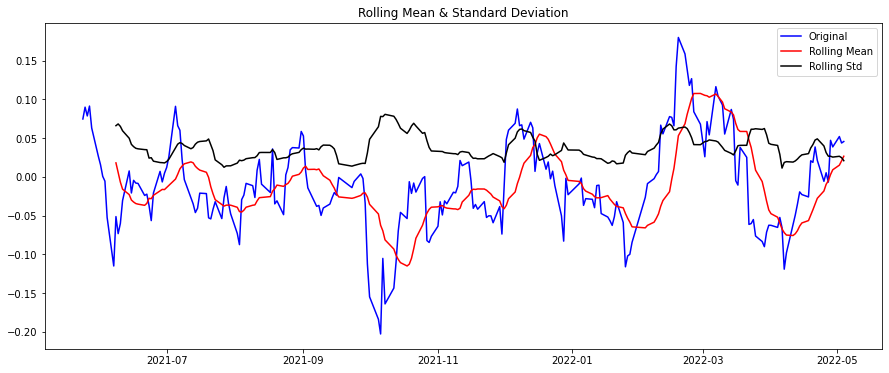

KCTC


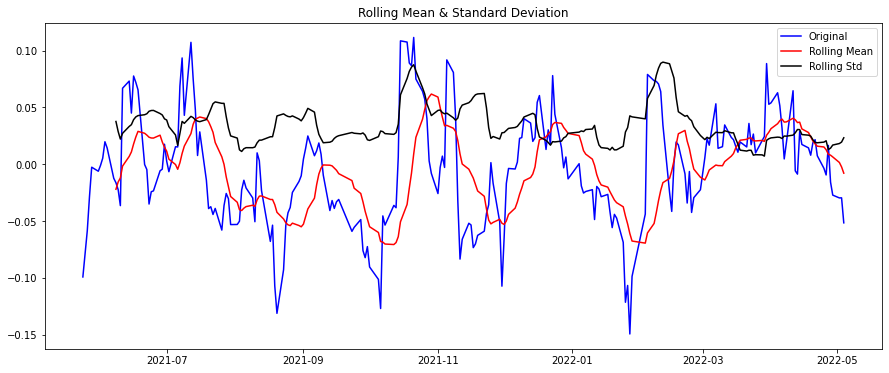

KIA


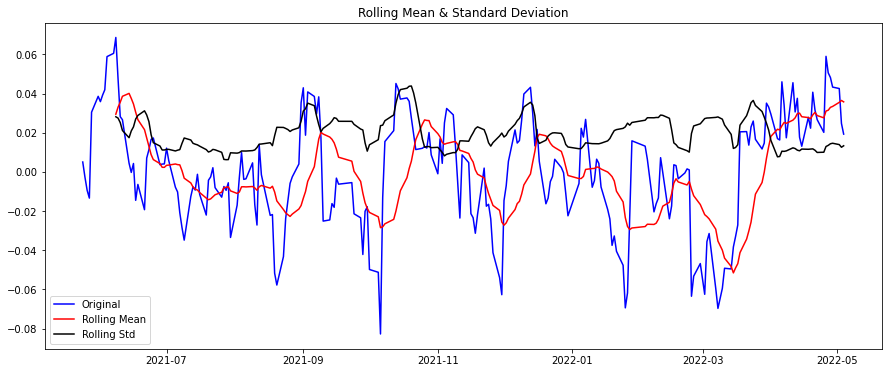

In [22]:
for i, j in LI2.items():
  print(i)
  plot_rolling_statistics(j)

숫자가 복잡해 보이더니 진짜 복잡하게 변햇습니다.

In [23]:
for i, j in LI2.items():
  print(i)
  augmented_dickey_fuller_test(j)
  print()

HMM
Result of Dickey-Fuller Test:
Test Statistic                  -3.914651
p-value                          0.001930
#Lags Used                       0.000000
Number of Observations Used    234.000000
Ciritical value (1%)            -3.458608
Ciritical value (5%)            -2.873972
Ciritical value (10%)           -2.573396
dtype: float64

KCTC
Result of Dickey-Fuller Test:
Test Statistic                  -5.062984
p-value                          0.000017
#Lags Used                       4.000000
Number of Observations Used    230.000000
Ciritical value (1%)            -3.459106
Ciritical value (5%)            -2.874190
Ciritical value (10%)           -2.573512
dtype: float64

KIA
Result of Dickey-Fuller Test:
Test Statistic                  -4.520442
p-value                          0.000181
#Lags Used                       0.000000
Number of Observations Used    234.000000
Ciritical value (1%)            -3.458608
Ciritical value (5%)            -2.873972
Ciritical value (10%)    

눈으로만 봐도 **p-value가 엄청나게 떨어지신 걸 확인**하실수 있습니다.

현재는 추이에 따라 평균이 증가하는 **추세를 제거했지만 아직 계절성이 남아**있습니다.

그것도 상쇄시켜 보도록 하겠습니다.

#차분 - 계절성 상쇄하기

**주기적인 패턴을 계절성**이라고 부릅니다.

이런 패턴을 조지기위한.... 아니 상쇄하기 위해서는 **차분**이 있습니다.

시계열을 **한 스텝 앞으로 쉬프트 시킨 다음 원래 시계열에서 앞으로 쉬프트 시킨 값을 빼줍니다**.

말로는 이해가 잘되지 않으니 직접 해보겠습니다.

직접 쉬프트한 그래프를 그려보겠습니다.

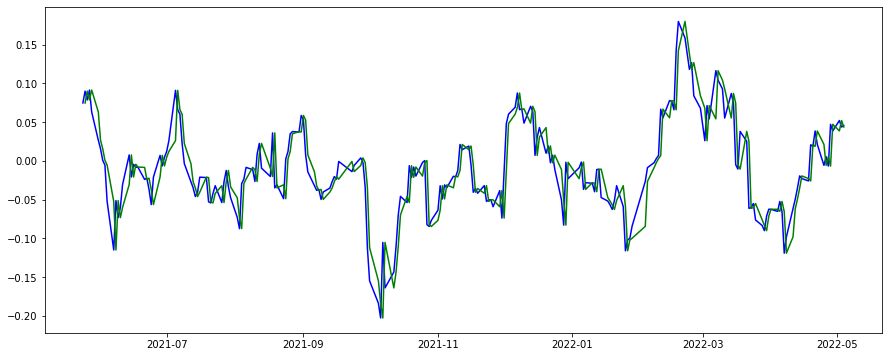

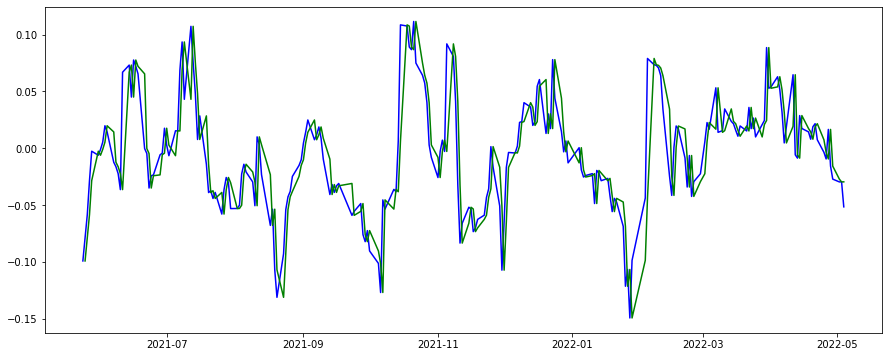

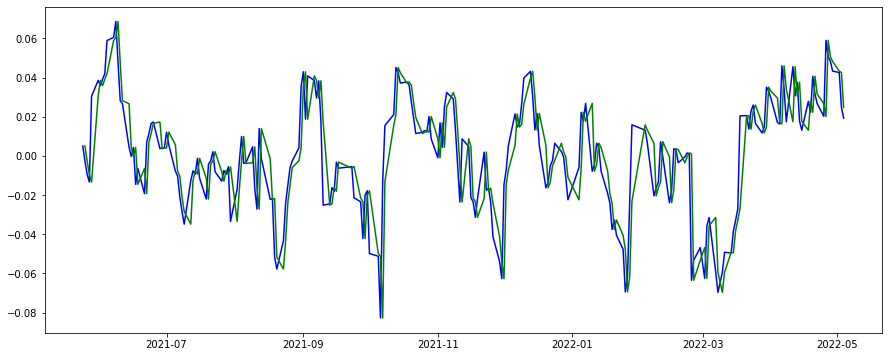

In [24]:
HMT_log_moving_avg_shift = HMT_log_moving_avg.shift()

plt.plot(HMT_log_moving_avg, color='blue')
plt.plot(HMT_log_moving_avg_shift, color='green')
plt.show()

KCT_log_moving_avg_shift = KCT_log_moving_avg.shift()

plt.plot(KCT_log_moving_avg, color='blue')
plt.plot(KCT_log_moving_avg_shift, color='green')
plt.show()

KIT_log_moving_avg_shift = KIT_log_moving_avg.shift()

plt.plot(KIT_log_moving_avg, color='blue')
plt.plot(KIT_log_moving_avg_shift, color='green')
plt.show()

뭔가 도수에 안맞는 안경을 쓰는 기분이 들지만 **한스텝 앞에 데이터를 불러오니 저렇게 보일수도 있다고 생각합니다**.

이제 **원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 확인해봅시다**.

참고로 데이터는 제목을 안달아서 따로 말씀드리자면 위에서 부터 HMM, KCTC, KIA 순입니다.

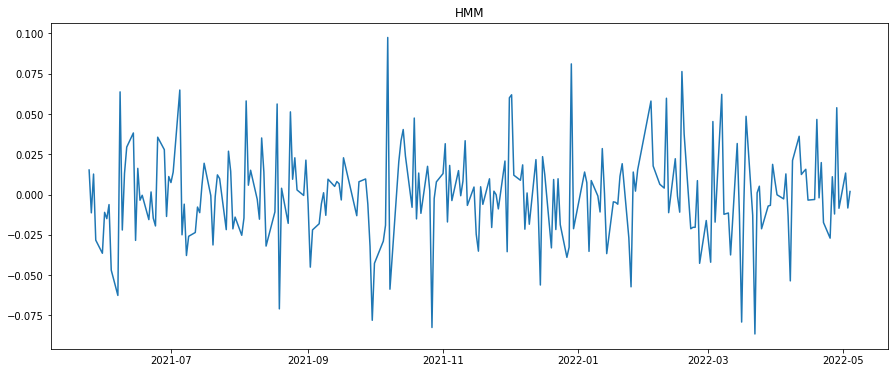

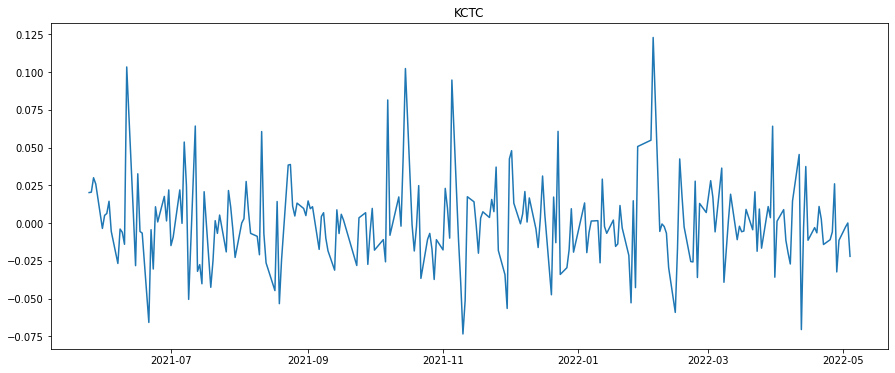

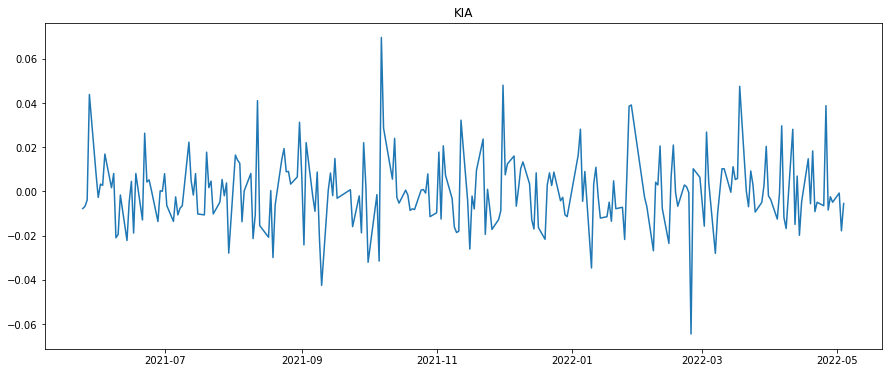

In [25]:
HMT_log_moving_avg_diff = HMT_log_moving_avg - HMT_log_moving_avg_shift
HMT_log_moving_avg_diff.dropna(inplace=True)
plt.title("HMM")
plt.plot(HMT_log_moving_avg_diff)
plt.show()

KCT_log_moving_avg_diff = KCT_log_moving_avg - KCT_log_moving_avg_shift
KCT_log_moving_avg_diff.dropna(inplace=True)
plt.title("KCTC")
plt.plot(KCT_log_moving_avg_diff)
plt.show()

KIT_log_moving_avg_diff = KIT_log_moving_avg - KIT_log_moving_avg_shift
KIT_log_moving_avg_diff.dropna(inplace=True)
plt.title("KIA")
plt.plot(KIT_log_moving_avg_diff)
plt.show()

이제 안전성 여부를 확인해보겠습니다.

HMM


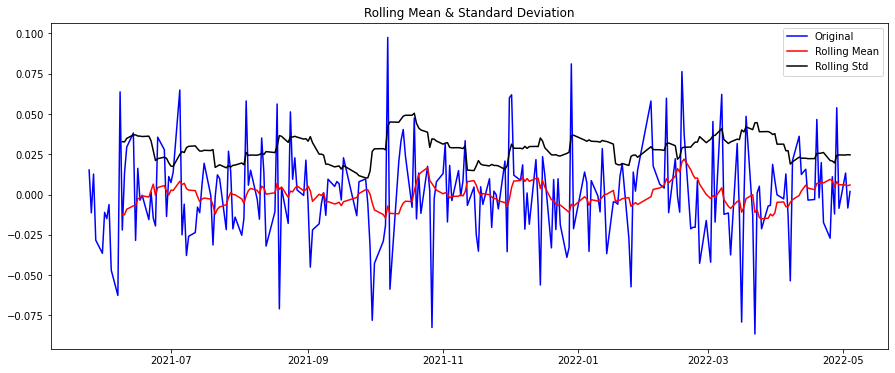

KCTC


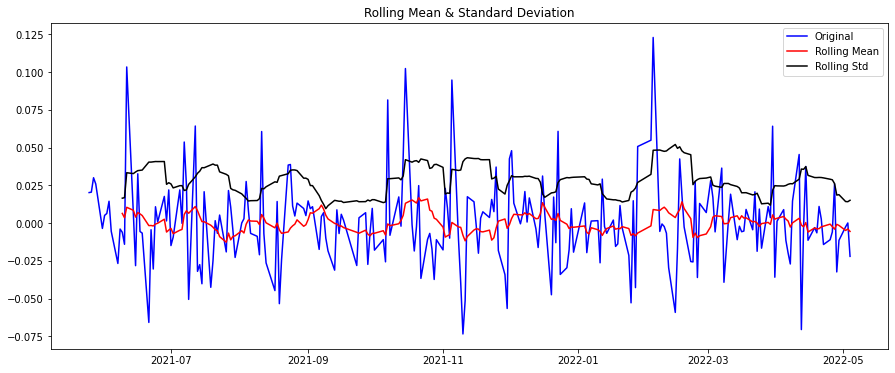

KIA


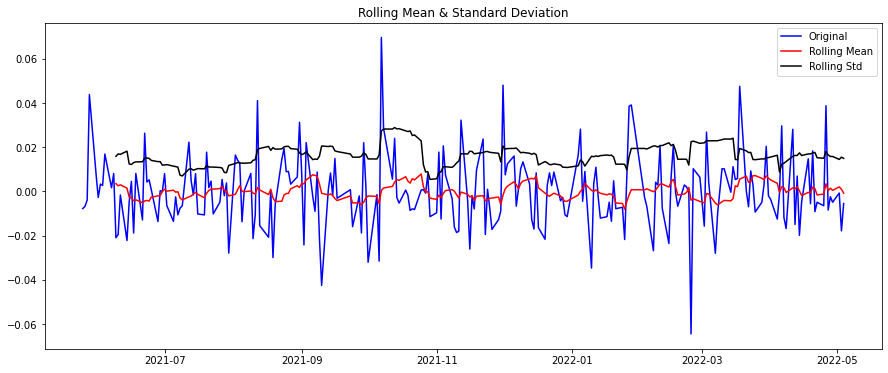

In [26]:
LI3 = {'HMM' : HMT_log_moving_avg_diff, 'KCTC' : KCT_log_moving_avg_diff, 'KIA' : KIT_log_moving_avg_diff}

for i, j in LI3.items():
  print(i)
  plot_rolling_statistics(j)

거의 다 왔습니다.

마지막으로 p_value값을 확인해볼까요?

In [27]:
for i, j in LI3.items():
  print(i)
  augmented_dickey_fuller_test(j)

HMM
Result of Dickey-Fuller Test:
Test Statistic                -1.588278e+01
p-value                        8.719270e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.330000e+02
Ciritical value (1%)          -3.458731e+00
Ciritical value (5%)          -2.874026e+00
Ciritical value (10%)         -2.573424e+00
dtype: float64
KCTC
Result of Dickey-Fuller Test:
Test Statistic                -7.988637e+00
p-value                        2.509099e-12
#Lags Used                     5.000000e+00
Number of Observations Used    2.280000e+02
Ciritical value (1%)          -3.459361e+00
Ciritical value (5%)          -2.874302e+00
Ciritical value (10%)         -2.573571e+00
dtype: float64
KIA
Result of Dickey-Fuller Test:
Test Statistic                -9.580991e+00
p-value                        2.158771e-16
#Lags Used                     3.000000e+00
Number of Observations Used    2.300000e+02
Ciritical value (1%)          -3.459106e+00
Ciritical value (5%)          -

??????? 차분을 했는 값이 줄기는 커녕 더 증가했습니다.

1보다 커져서 괜찮긴 한거 같습니다.

하지만 두개의 주식은 1하고 가까운 쪽으로 변하거 같습니다.

방금까지 세운식을 **메소드로도 간편하게 끝낼 수 있습니다**.

그쪽에서도 한번 확인해보겠습니다.

---

#토막상식(오류 코드)

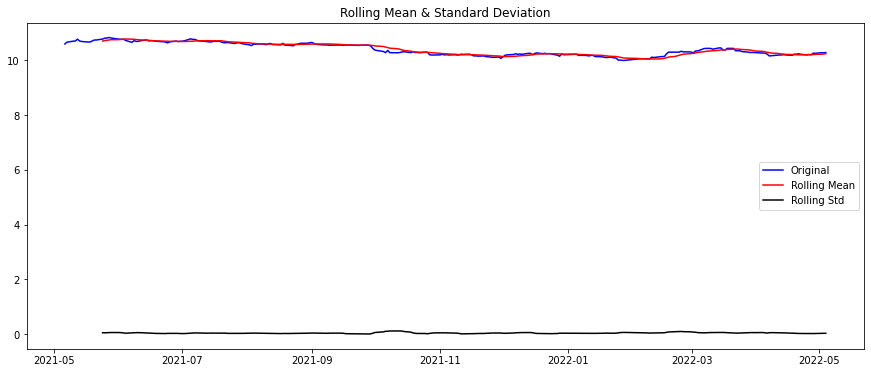

Result of Dickey-Fuller Test:
Test Statistic                  -1.176053
p-value                          0.683811
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64


TypeError: ignored

In [41]:
for i, j in LI1.items():
# 정성적 그래프 분석
  plot_rolling_statistics(j, window=12)

#정량적 Augmented Dicky-Fuller Test
  augmented_dickey_fuller_test(j)

#시계열 분해 (Time Series Decomposition)
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(j, model='multiplicative', period = 30) 
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.title(i)
  plt.subplot(411)
  plt.plot(j, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()
  residual.dropna(inplace=True)
  augmented_dickey_fuller_test(residual)

**주의 하실점**

코랩에서만 그런건지는 모르겠습니다만, **실습 코드처럼 period 입력하게 되면 유효하지 않은 키라고 오류가** 뜹니다.

**freq 이걸로 바꿔서 입력해 주세요**

---

#제대로 된 코드(메소드로 간편하게)

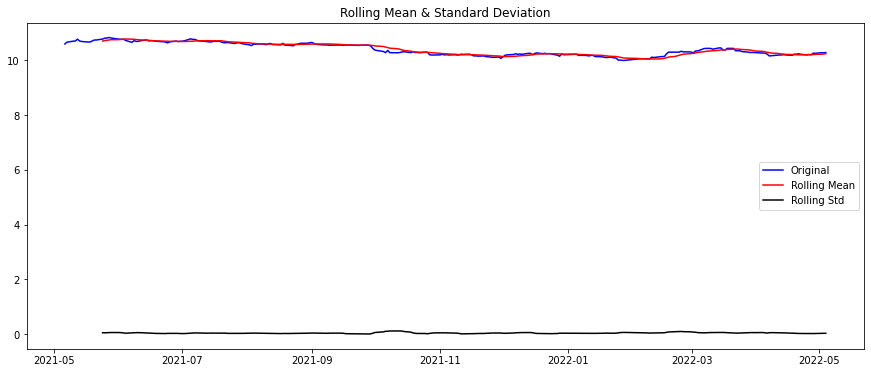

Result of Dickey-Fuller Test:
Test Statistic                  -1.176053
p-value                          0.683811
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64


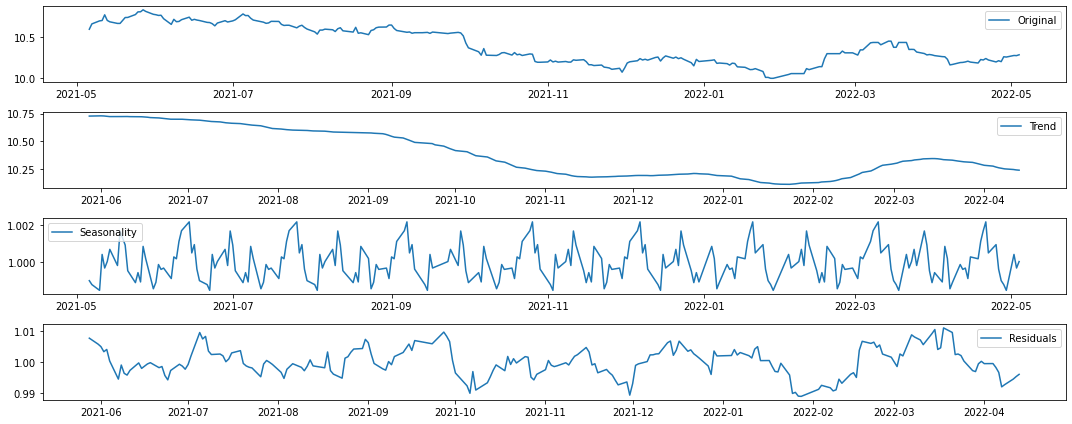

Result of Dickey-Fuller Test:
Test Statistic                  -4.590233
p-value                          0.000135
#Lags Used                       0.000000
Number of Observations Used    215.000000
Ciritical value (1%)            -3.461136
Ciritical value (5%)            -2.875079
Ciritical value (10%)           -2.573986
dtype: float64


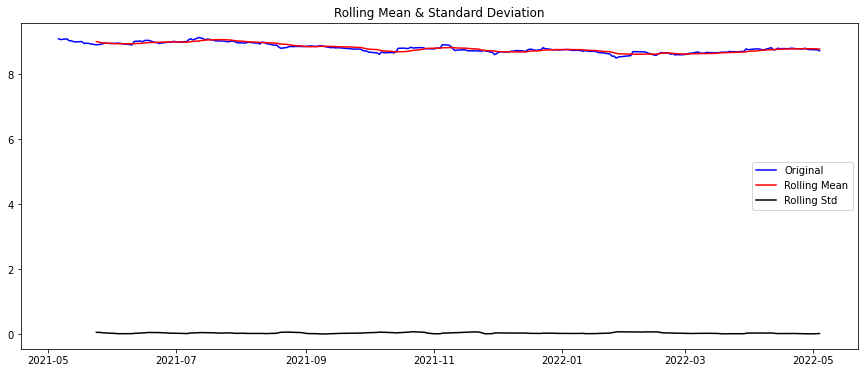

Result of Dickey-Fuller Test:
Test Statistic                  -2.228901
p-value                          0.195924
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64


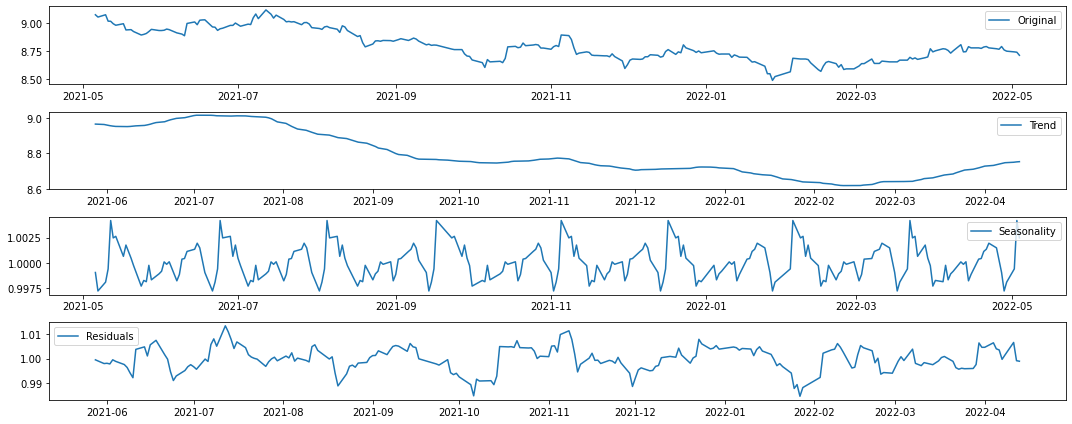

Result of Dickey-Fuller Test:
Test Statistic                  -5.338044
p-value                          0.000005
#Lags Used                       9.000000
Number of Observations Used    206.000000
Ciritical value (1%)            -3.462499
Ciritical value (5%)            -2.875675
Ciritical value (10%)           -2.574304
dtype: float64


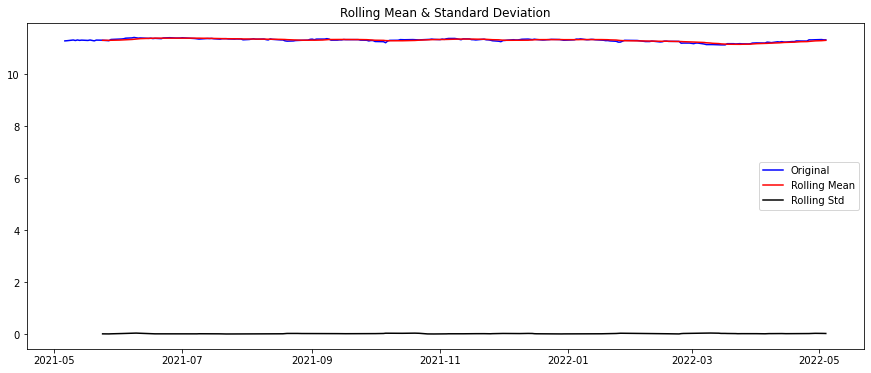

Result of Dickey-Fuller Test:
Test Statistic                  -2.166732
p-value                          0.218541
#Lags Used                       0.000000
Number of Observations Used    245.000000
Ciritical value (1%)            -3.457326
Ciritical value (5%)            -2.873410
Ciritical value (10%)           -2.573096
dtype: float64


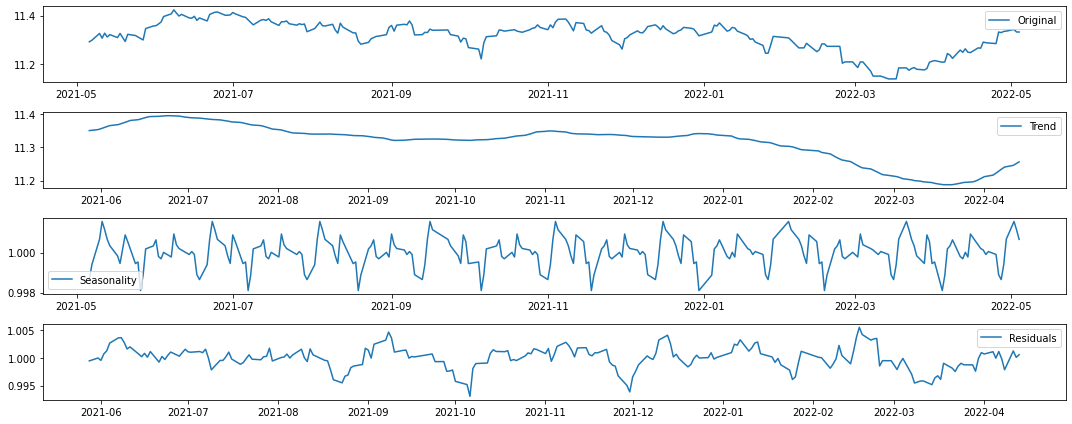

Result of Dickey-Fuller Test:
Test Statistic                  -4.940474
p-value                          0.000029
#Lags Used                       0.000000
Number of Observations Used    215.000000
Ciritical value (1%)            -3.461136
Ciritical value (5%)            -2.875079
Ciritical value (10%)           -2.573986
dtype: float64


In [28]:
for i, j in LI1.items():
# 정성적 그래프 분석
  plot_rolling_statistics(j, window=12)

#정량적 Augmented Dicky-Fuller Test
  augmented_dickey_fuller_test(j)

#시계열 분해 (Time Series Decomposition)
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(j, model='multiplicative', freq = 30) 
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.title(i)
  plt.subplot(411)
  plt.plot(j, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()
  residual.dropna(inplace=True)
  augmented_dickey_fuller_test(residual)


**원본 시계열에서 추세와 계절성을 제거하고 난 나머지를 Residuals**라고 합니다.

뒤집어서 말하면 원본 데이터는 저 3가지를 더한 값이라는 것입니다.

위에서 부터 HMM, KCTC, KIA 순입니다.


```
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
```


이걸로 얻어진 residual은 압도적으로 낮은 p-value값이 보여지고 있습니다.

**이정도 값이면 예측이 가능한 수준의 안정적인 시계열이 얻어**졌다고 봐도 될꺼 같습니다.

---

#모델 학습과 결과 출력

ARIMA 모델은 파라미터로 **p, q, d를 사용**합니다.

각각의 의미는 이렇습니다.

**p : 자기 회귀 차수**

**q : 차분 차수**

**d : 이동 평균 차수**

여기서 q와 p는 **acf와 pacf를 통하여** 구할 수 있습니다.

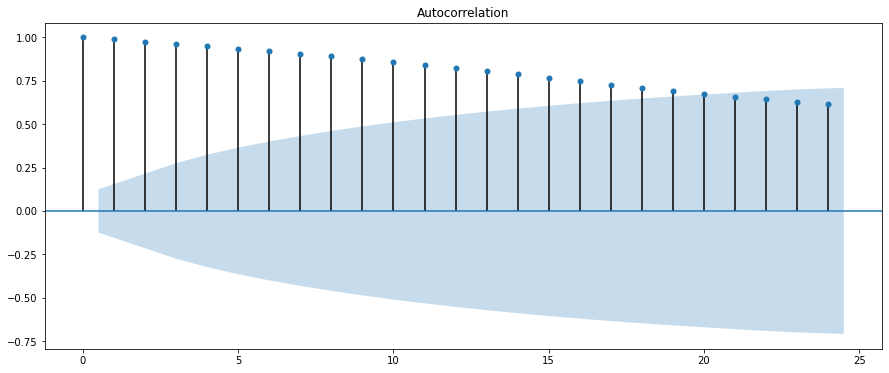

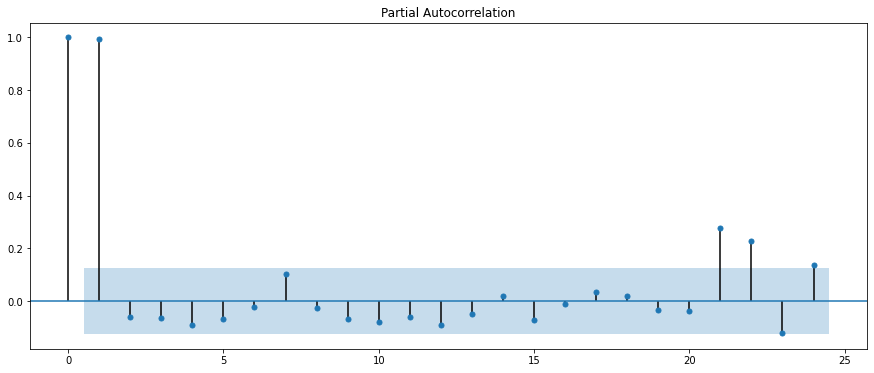

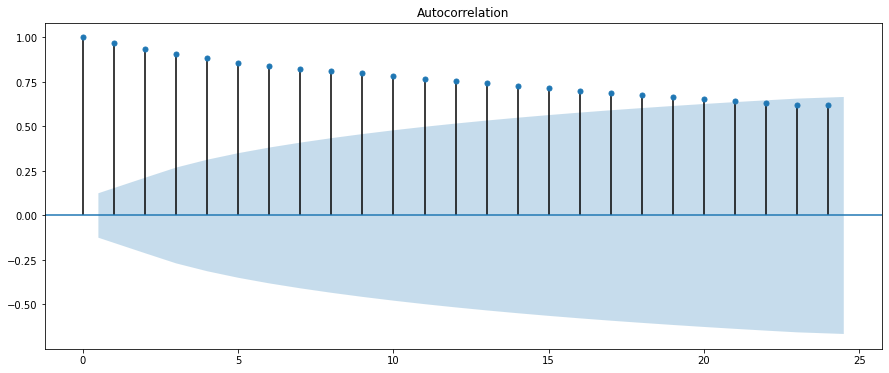

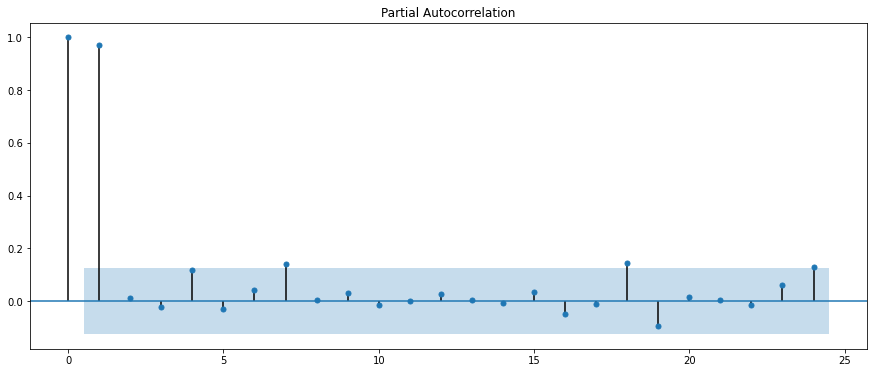

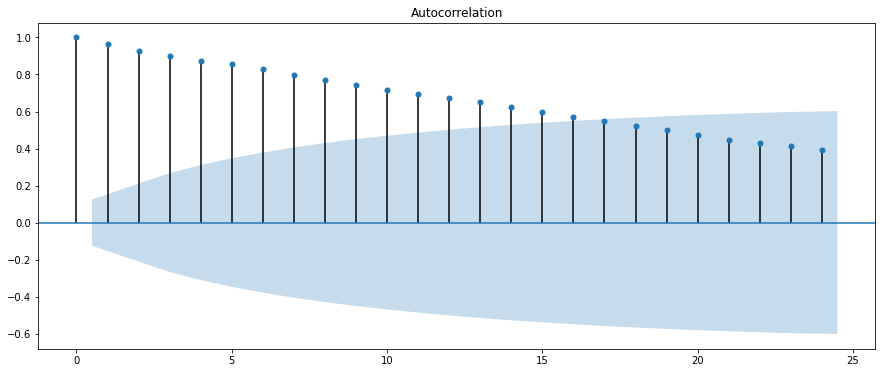

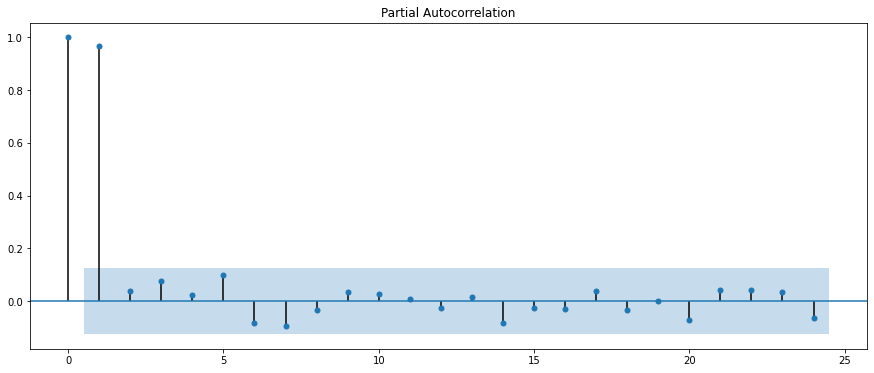

In [29]:
for i,j in LI1.items():
  plot_acf(j)
  plot_pacf(j)
  plt.show()

모수의 개념을 확실하게는 모르지만

**p + q < 2, p * q = 0**이란것을 알 수 있습니다.

여기서 한번 임의값으로 **p에는 1 ~ 10 까지 숫자를 그리고 q는 시계열을 정지 상태로 만들것이기 때문에 0으로 설정**하고 해보겠습니다.

그리고 **d값은 차분을 해서 구할수 있습니다**.

일단 **d를 1로 설정한다고 가정하고 계산**해보겠습니다.

In [30]:
print('HMM')
HM_diff_1 = HMT_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(HM_diff_1)
print()

print('KCTC')
KC_diff_1 = KCT_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(KC_diff_1)
print()

print('KIA')
KI_diff_1 = KIT_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(KI_diff_1)
print()

HMM
Result of Dickey-Fuller Test:
Test Statistic                -1.603639e+01
p-value                        5.979676e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Ciritical value (1%)          -3.457438e+00
Ciritical value (5%)          -2.873459e+00
Ciritical value (10%)         -2.573122e+00
dtype: float64

KCTC
Result of Dickey-Fuller Test:
Test Statistic                -1.551259e+01
p-value                        2.338183e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Ciritical value (1%)          -3.457438e+00
Ciritical value (5%)          -2.873459e+00
Ciritical value (10%)         -2.573122e+00
dtype: float64

KIA
Result of Dickey-Fuller Test:
Test Statistic                -1.222635e+01
p-value                        1.078290e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Ciritical value (1%)          -3.457551e+00
Ciritical value (5%)         

1에서 충분히 벗어나는 값으로 **d = 1로 지정해서 해도 문제가 없을꺼 같습니다**.

**d = 1**로 설정하겠습니다.

**KIA만 d = 0** 으로 하겠습니다.

그 다음은 **학습데이터를 분리** 하겠습니다.

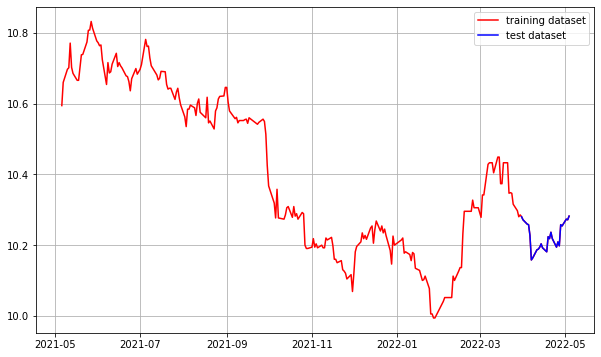

In [31]:
HM_train_data, HM_test_data = HMT_log[:int(len(HMT_log)*0.9)], HMT_log[int(len(HMT_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(HMT_log, c='r', label='training dataset')
plt.plot(HM_test_data, c='b', label='test dataset')
plt.legend()

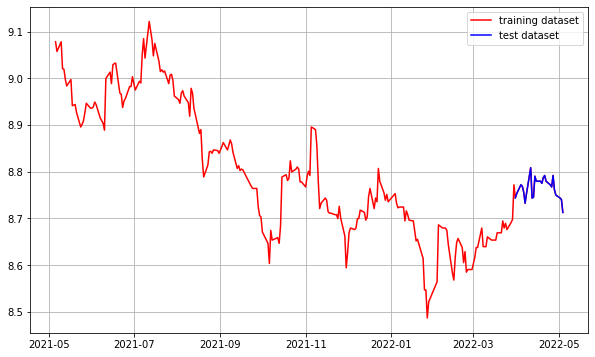

In [32]:
KC_train_data, KC_test_data = KCT_log[:int(len(KCT_log)*0.9)], KCT_log[int(len(KCT_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(KCT_log, c='r', label='training dataset')
plt.plot(KC_test_data, c='b', label='test dataset')
plt.legend()

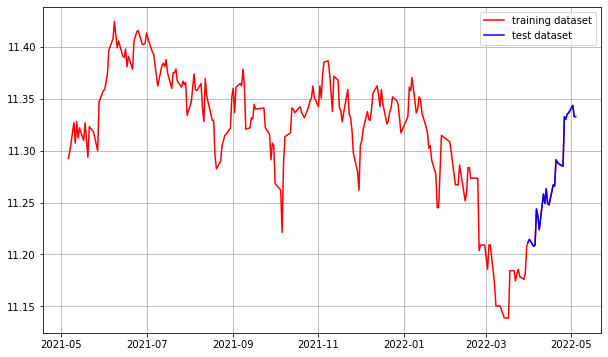

In [33]:
KI_train_data, KI_test_data = KIT_log[:int(len(KIT_log)*0.9)], KIT_log[int(len(KIT_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(KIT_log, c='r', label='training dataset')
plt.plot(KI_test_data, c='b', label='test dataset')
plt.legend()

In [34]:
print('HMM')
print(HMT_log[:2])
print(HM_train_data.shape)
print(HM_test_data.shape)

HMM
Date
2021-05-06    10.594132
2021-05-07    10.659610
Name: Close, dtype: float64
(221,)
(25,)


In [35]:
print('KCTC')
print(KCT_log[:2])
print(KC_train_data.shape)
print(KC_test_data.shape)

KCTC
Date
2021-05-06    9.077951
2021-05-07    9.057189
Name: Close, dtype: float64
(221,)
(25,)


In [36]:
print('KIA')
print(KIT_log[:2])
print(KI_train_data.shape)
print(KI_test_data.shape)

KIA
Date
2021-05-06    11.292279
2021-05-07    11.298494
Name: Close, dtype: float64
(221,)
(25,)


문제없이 잘 분리가 이루어진거 같습니다.

위에서 학습을 90퍼로 설정하고 테스트를 10으로 설정하여 저런 값이 들어갔습니다.

In [37]:
def print_score(y_label, y_pred) :

    mse = mean_squared_error(np.exp(y_label), np.exp(y_pred))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(y_label), np.exp(y_pred))
    print('MAE: ', mae)

    rmse = math.sqrt(mse)
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(y_pred) - np.exp(y_label))/np.abs(np.exp(y_label)))
    print('MAPE: {:.2f}%'.format(mape*100))

미리 손실 함수를 지정해 놓겠습니다.

그리고 **ARIMA(p, d, q)에서 d는 1로 정했습니다**.

**KIA만 d = 0 입니다.**

이동 **평균 차수인 q는 시계열을 정지 상태로 만들것이기 때문에 0으로 하겠습니다**.

그리고 p값에는 **한번 1~10까지 10가지 값을 넣어서 성능을 비교**하겠습니다.

#HMM 결과

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


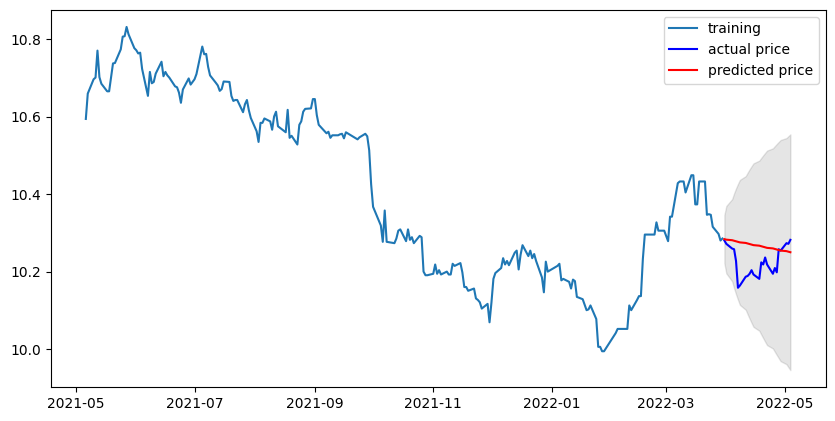

MSE:  2658434.3935818165
MAE:  1358.6520431731362
RMSE:  1630.4706049425781
MAPE: 5.05%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


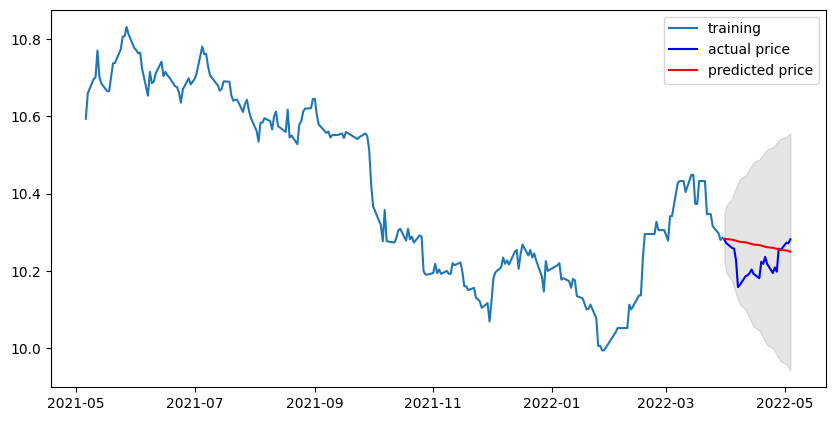

MSE:  2655788.547025893
MAE:  1357.695276247728
RMSE:  1629.659027841681
MAPE: 5.04%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


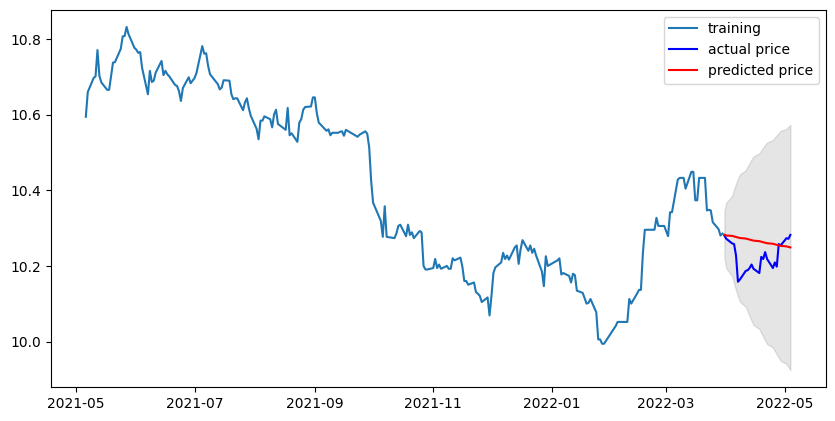

MSE:  2555832.9386142995
MAE:  1330.7338650458394
RMSE:  1598.6972629657873
MAPE: 4.94%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


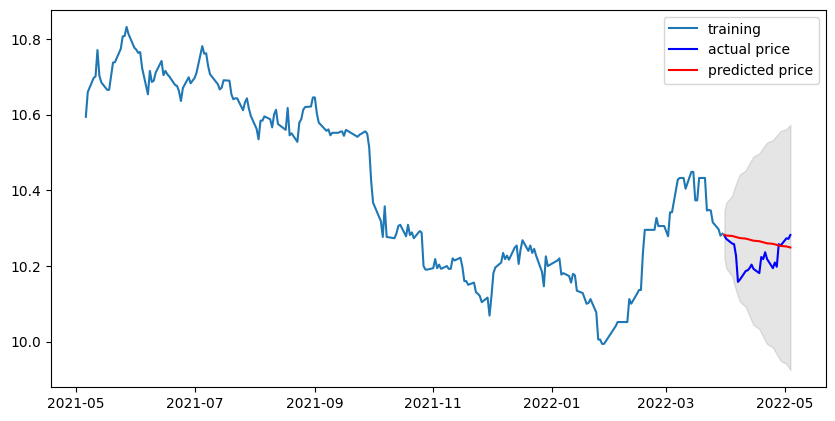

MSE:  2560063.78508471
MAE:  1331.830419899478
RMSE:  1600.0199327148116
MAPE: 4.95%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


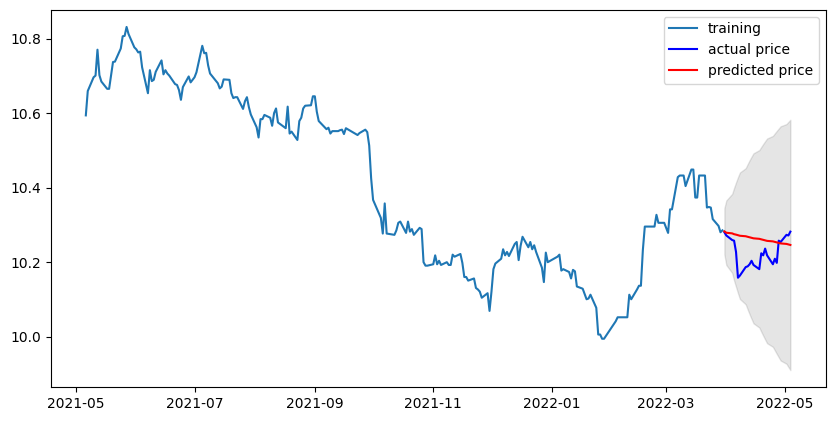

MSE:  2379642.6733910907
MAE:  1287.6714194524973
RMSE:  1542.609047487759
MAPE: 4.78%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


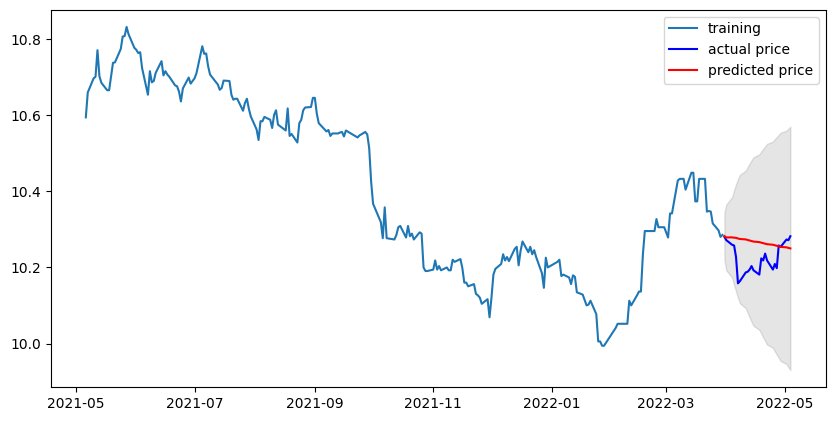

MSE:  2623242.6325555528
MAE:  1342.2903998100064
RMSE:  1619.6427484342196
MAPE: 4.99%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


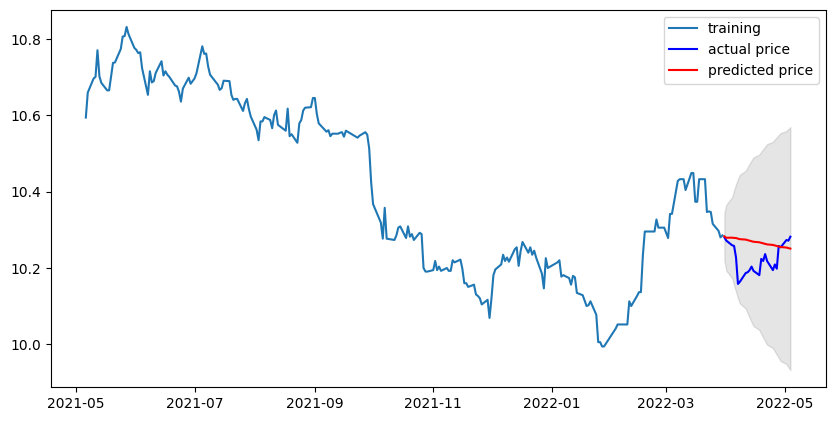

MSE:  2675145.967418172
MAE:  1355.8848628474111
RMSE:  1635.5873463126852
MAPE: 5.04%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


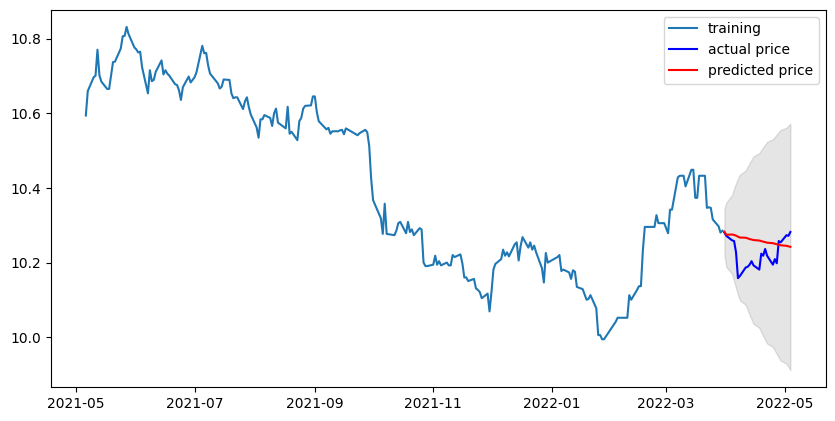

MSE:  2181981.763165949
MAE:  1237.0017342976153
RMSE:  1477.1532632621263
MAPE: 4.59%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


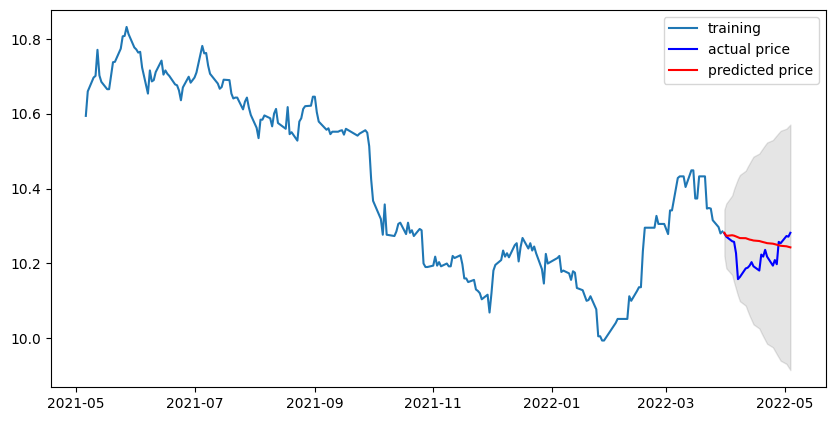

MSE:  2228465.6173984967
MAE:  1246.261943035682
RMSE:  1492.8046146091915
MAPE: 4.63%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


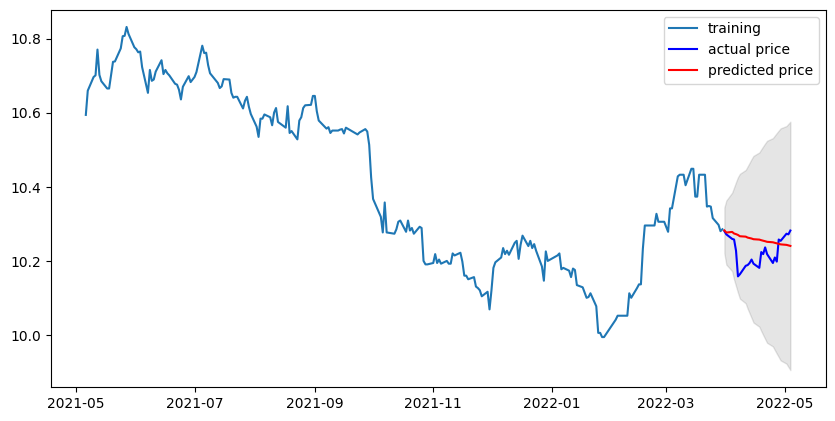

MSE:  2130611.660006777
MAE:  1227.8808184576108
RMSE:  1459.6614881563385
MAPE: 4.55%


In [38]:
for i in range(1, 11):

  model = ARIMA(HM_train_data, order=(i, 1, 0))
  fitted_m = model.fit()

  f, so, sci = fitted_m.forecast(len(HM_test_data), alpha = 0.05)

  fc_series = pd.Series(f, index = HM_test_data.index) 
  lower_series = pd.Series(sci[:, 0], index = HM_test_data.index) 
  upper_series = pd.Series(sci[:, 1], index = HM_test_data.index)  

  plt.figure(figsize = (10,5), dpi = 100)
  plt.plot(HM_train_data, label = 'training')
  plt.plot(HM_test_data, c='b', label = 'actual price')
  plt.plot(fc_series, c = 'r', label = 'predicted price')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
  plt.legend()
  plt.show()
  print_score(HM_test_data, f)

#KCTC 결과

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


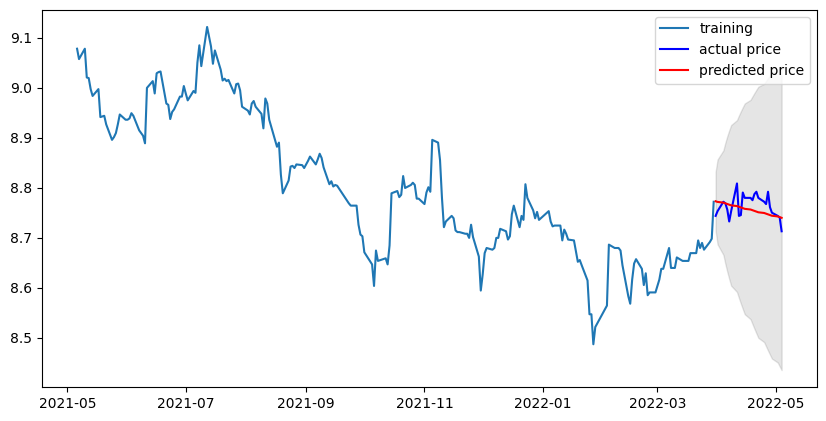

MSE:  24777.93463575188
MAE:  133.1805614765582
RMSE:  157.41008428862455
MAPE: 2.07%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


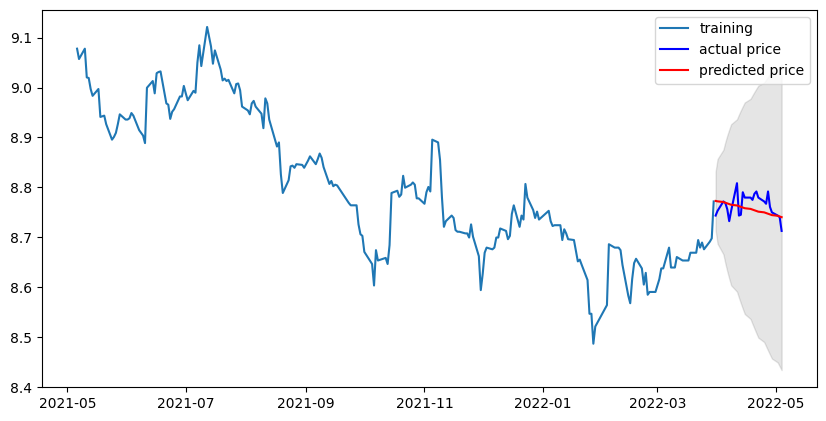

MSE:  24351.732829967917
MAE:  132.23458493085883
RMSE:  156.05041758985433
MAPE: 2.05%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


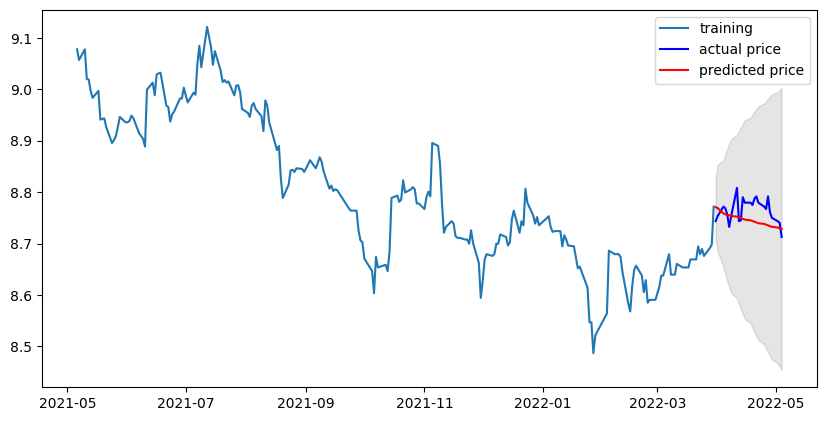

MSE:  37703.70071299126
MAE:  163.19328381665923
RMSE:  194.174407976415
MAPE: 2.52%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


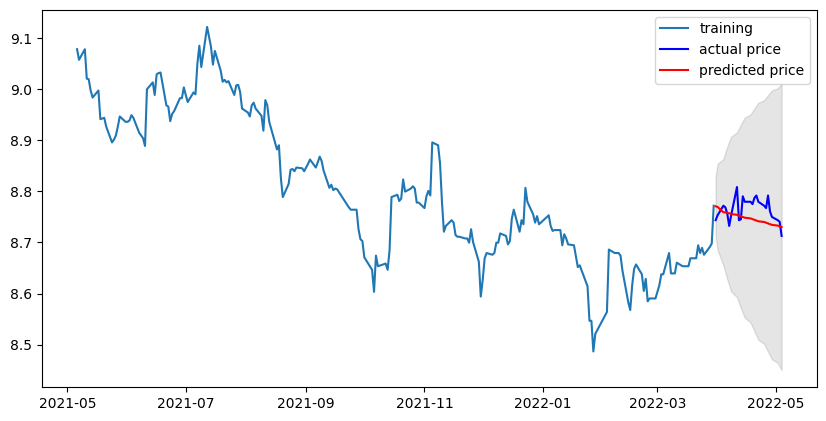

MSE:  35003.65675542265
MAE:  158.1747517360108
RMSE:  187.09264217339668
MAPE: 2.45%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


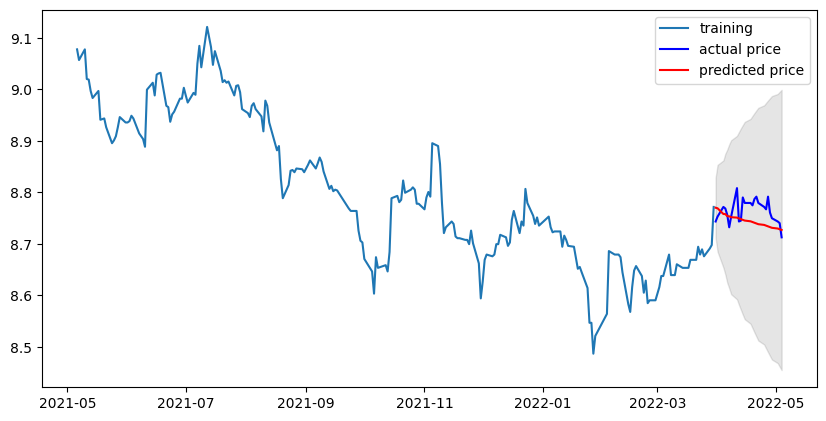

MSE:  39588.76792412214
MAE:  166.85203994421795
RMSE:  198.96926376735212
MAPE: 2.58%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


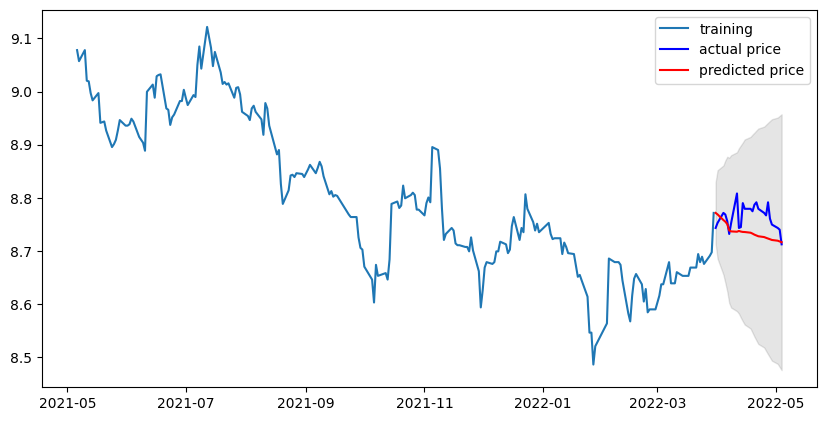

MSE:  60229.750353674
MAE:  206.26095680921887
RMSE:  245.41750213396352
MAPE: 3.19%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


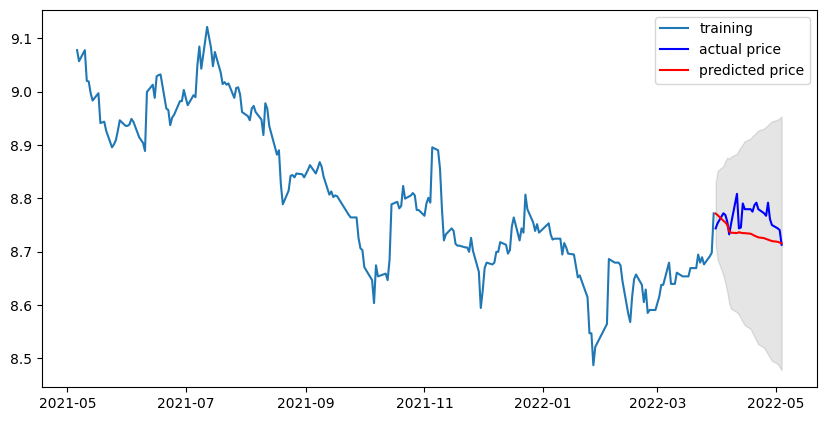

MSE:  63145.23155487677
MAE:  211.7709052594086
RMSE:  251.28714960155995
MAPE: 3.27%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


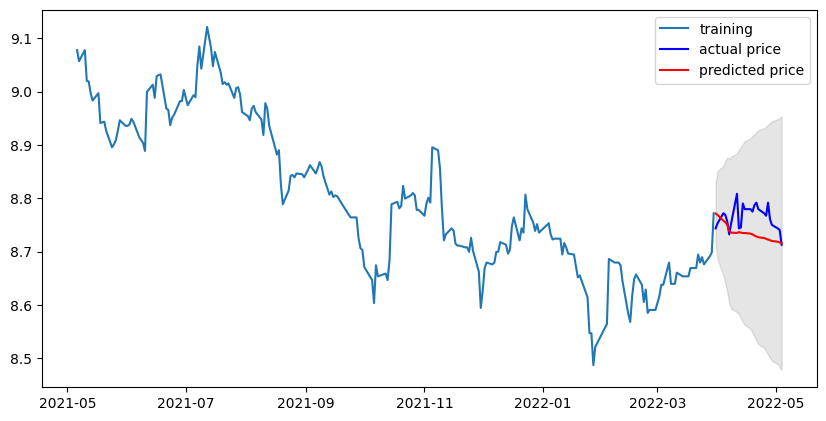

MSE:  62825.46187121327
MAE:  211.1848249788766
RMSE:  250.65007853821484
MAPE: 3.26%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


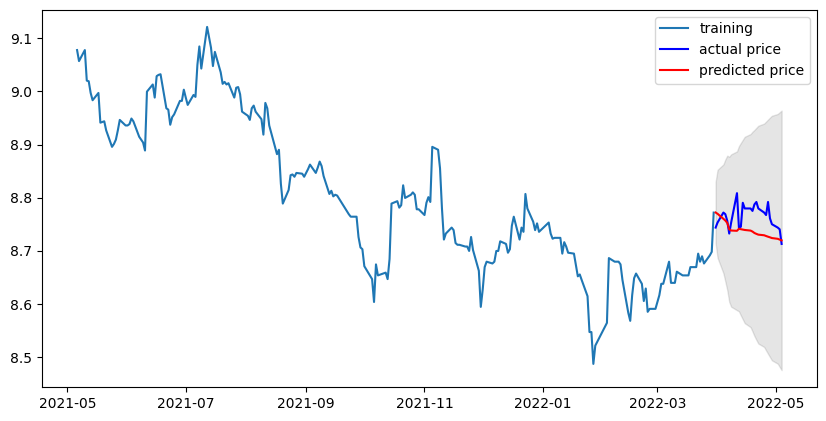

MSE:  54472.601394317484
MAE:  194.15524466555246
RMSE:  233.39366185549574
MAPE: 3.00%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


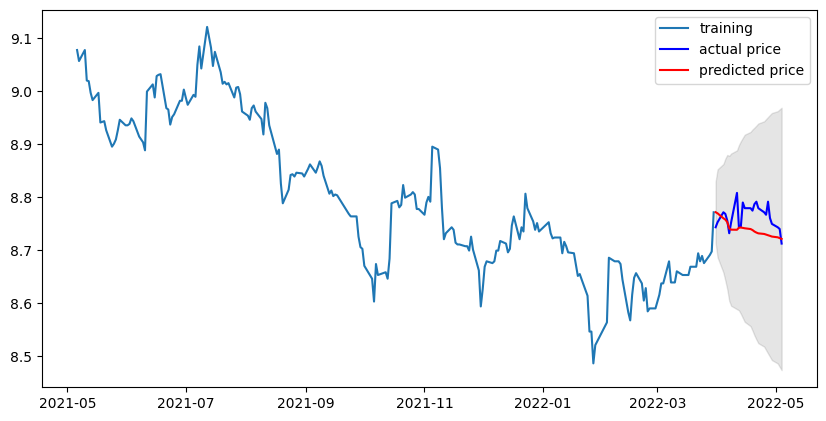

MSE:  50251.9766735574
MAE:  185.2970369198174
RMSE:  224.1695266390091
MAPE: 2.86%


In [39]:
for i in range(1, 11):

  model = ARIMA(KC_train_data, order=(i, 1, 0))
  fitted_m = model.fit()

  f, so, sci = fitted_m.forecast(len(KC_test_data), alpha = 0.05)

  fc_series = pd.Series(f, index = KC_test_data.index) 
  lower_series = pd.Series(sci[:, 0], index = KC_test_data.index) 
  upper_series = pd.Series(sci[:, 1], index = KC_test_data.index)  

  plt.figure(figsize = (10,5), dpi = 100)
  plt.plot(KC_train_data, label = 'training')
  plt.plot(KC_test_data, c='b', label = 'actual price')
  plt.plot(fc_series, c = 'r', label = 'predicted price')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
  plt.legend()
  plt.show()
  print_score(KC_test_data, f)

#KIA 결과

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


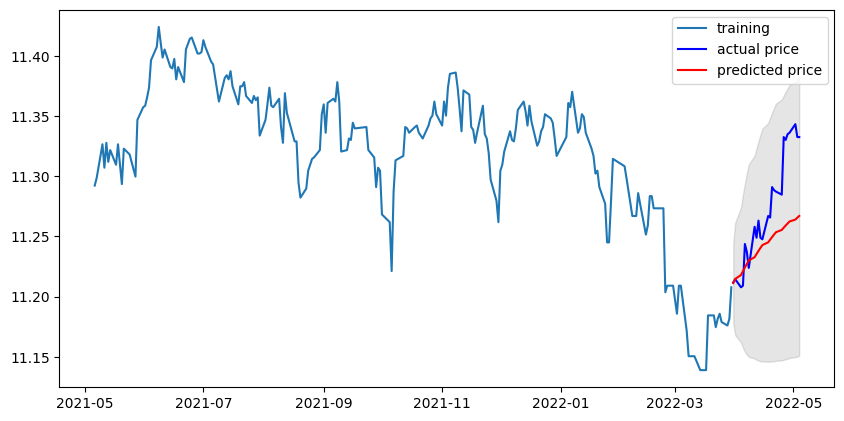

MSE:  11564362.450848479
MAE:  2615.955929802096
RMSE:  3400.6414763759612
MAPE: 3.21%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


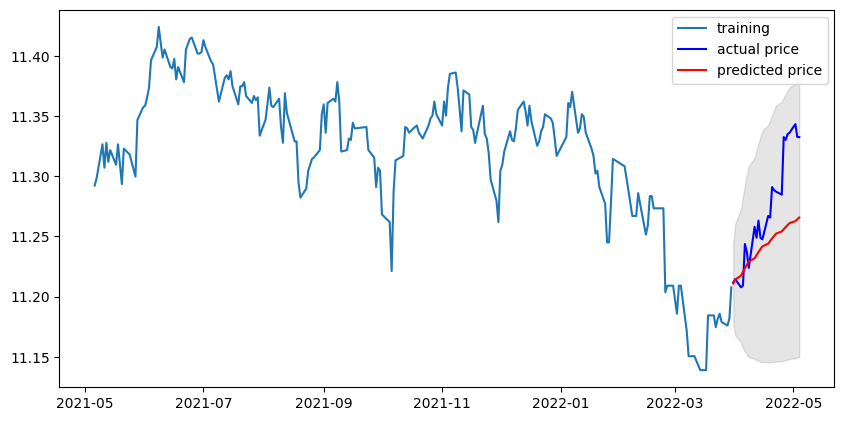

MSE:  12045908.124475338
MAE:  2681.410259512715
RMSE:  3470.721556748011
MAPE: 3.29%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


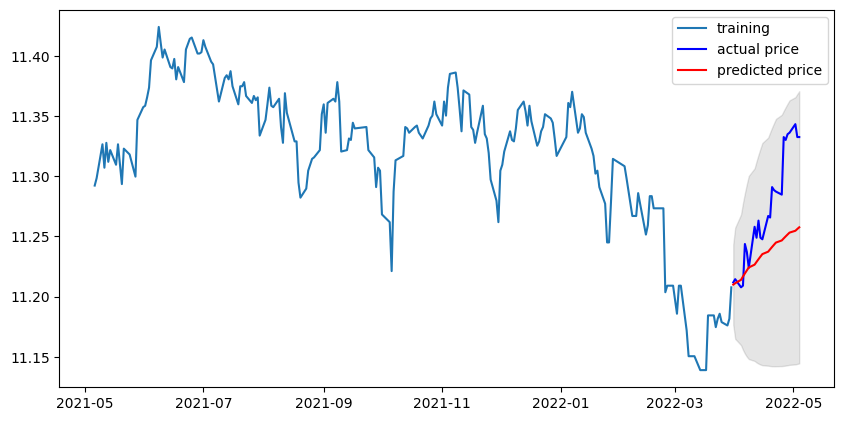

MSE:  15194760.729996748
MAE:  3073.4560790849328
RMSE:  3898.0457578120795
MAPE: 3.78%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


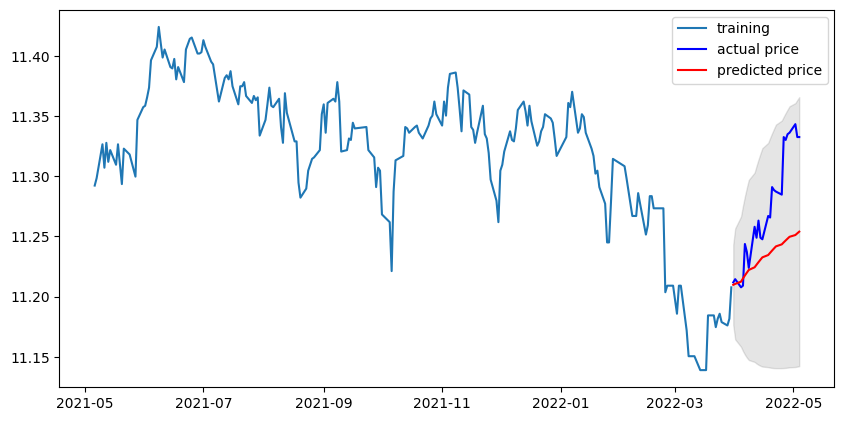

MSE:  16702085.611607444
MAE:  3248.6670533117826
RMSE:  4086.8185195341675
MAPE: 3.99%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


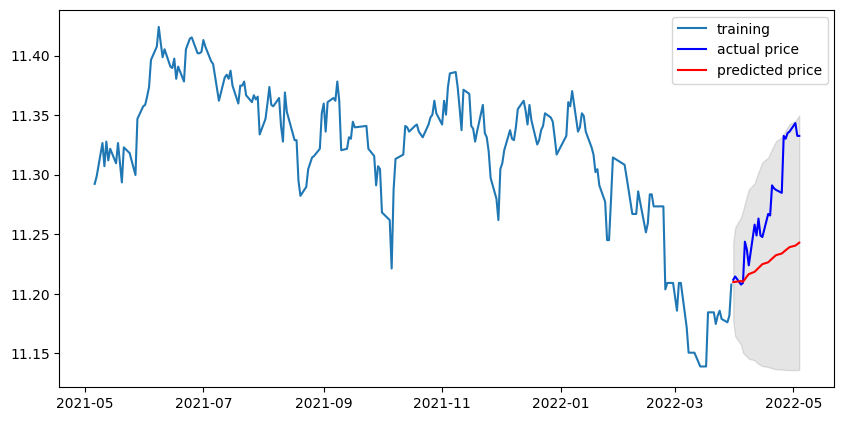

MSE:  21675760.47847252
MAE:  3770.335847172129
RMSE:  4655.72341086458
MAPE: 4.64%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


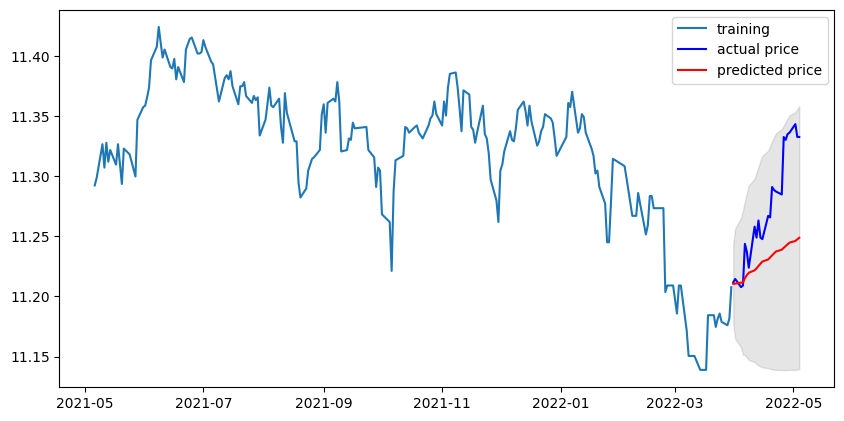

MSE:  18941147.369427815
MAE:  3485.2260717672953
RMSE:  4352.1428480034765
MAPE: 4.29%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


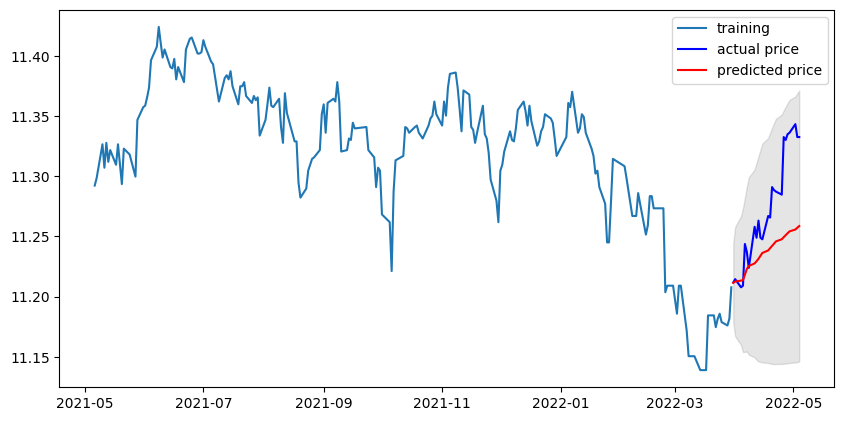

MSE:  14761388.708663287
MAE:  3007.6552322582306
RMSE:  3842.055271422222
MAPE: 3.69%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


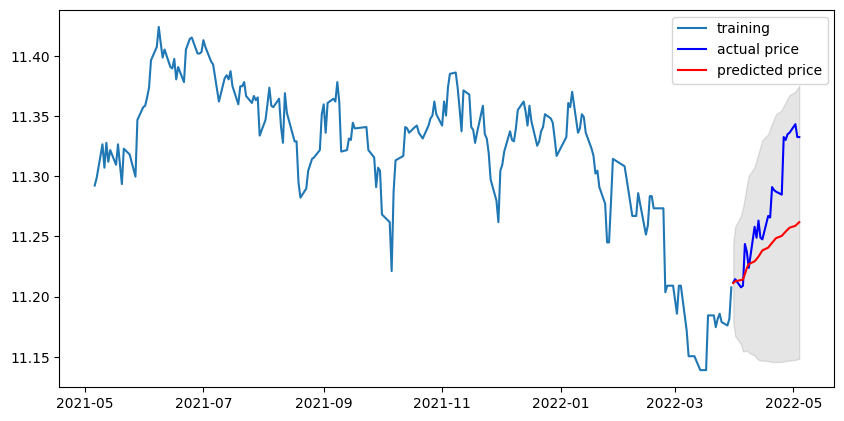

MSE:  13561269.229592815
MAE:  2869.254263182867
RMSE:  3682.5628615941937
MAPE: 3.52%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


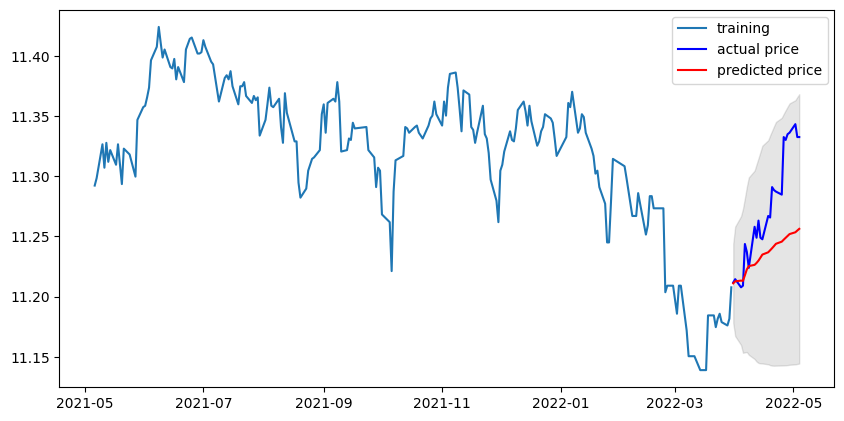

MSE:  15681393.202776527
MAE:  3112.1906703458926
RMSE:  3959.9738891533775
MAPE: 3.82%


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


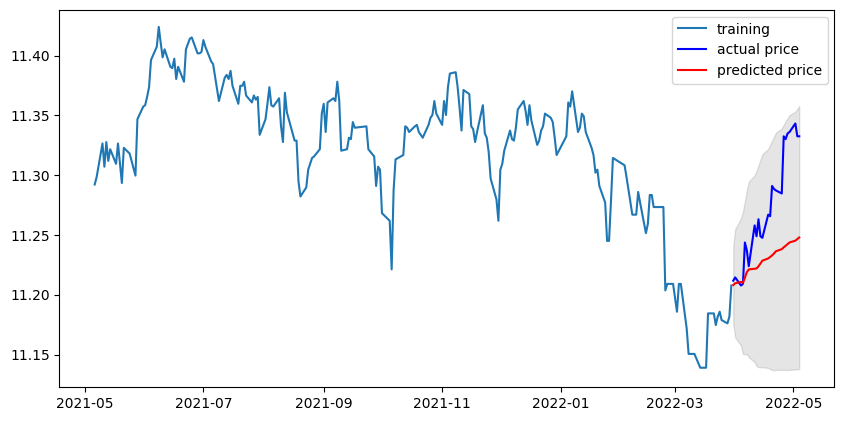

MSE:  19400092.436592106
MAE:  3531.736326600523
RMSE:  4404.553602420126
MAPE: 4.34%


In [40]:
for i in range(1, 11):

  model = ARIMA(KI_train_data, order=(i, 0, 0))
  fitted_m = model.fit()

  f, so, sci = fitted_m.forecast(len(KI_test_data), alpha = 0.05)

  fc_series = pd.Series(f, index = KI_test_data.index) 
  lower_series = pd.Series(sci[:, 0], index = KI_test_data.index) 
  upper_series = pd.Series(sci[:, 1], index = KI_test_data.index)  

  plt.figure(figsize = (10,5), dpi = 100)
  plt.plot(KI_train_data, label = 'training')
  plt.plot(KI_test_data, c='b', label = 'actual price')
  plt.plot(fc_series, c = 'r', label = 'predicted price')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
  plt.legend()
  plt.show()
  print_score(KI_test_data, f)

#마무리
그 어떠한 프로젝트보다 **어려웠습니다**.

통계적 배경지식이 깔려있는 상태에서 시작해야할꺼 같은 프로젝트였습니다.

아직도 **이론 중에서 일부분이 이해가 잘되지는 않습니다만, 프로젝트를 진행하지 않을때보단 이해가 잘되는 기분**입니다.

다만 주식 데이터 자체를 시계열 데이터로 예측하기에는 **외부적인 요소에 의해 영향을 많이 받는거 같습니다**.

대표적으로는 코로나가 있습니다.

그리고 **배당, 인수, 합병 등등에 의하여 주식이 급격하게 변하고는 합니다**.

결국에는 이러한 변화에 의해 **시계열 데이터에 대한 안전성이 훼손될 수도 있다는 느낌을 받았습니다**.

더 나아가서는 **외부적인 요인도 추가할 수 있는 모델을 만들고 싶습니다**.

추가적으로 몇가지 느낀점은 **적절한 모수를 찾았더라도 다른값을 넣어보는것도 좋을꺼 같습니다**.

오히려 아무렇게나 넣었는데 **성능이 더 좋은 경우가 종종 있었습니다**. ㄷㄷㄷㄷ

그 다음으로는 재미있었습니다. 

왜냐하면 주가같은 경우는 안전성이 확보되어있지 데이터가 많을텐데 그 데이터를 가공하는 과정이 인상 깊었습니다.

시계열이라는 분야는 아예 몰랐지만 그래도 이번 프로젝트로 가볍게나마 알고 가는거 같습니다.

